# Machine Learning Pipeline
The work here expects that feature engineering has been applied to the data so all that needs to be done is reading in a data matrix and performing minimal preprocessing, feature selection, training, and performance metric ouptut. Everything is being done in a pipelien which runs straight from input to cv output, but I can fit it first and look at intermediate results if needed.
## Notes

## TODO
1. Open up some of the pipeline so you can look at intermediate results like features selected.
2. Can feature selection be done in a cv way so you can pass all the intersection of all features instead of performing 1 feature selection pass on the current training set
3. Save the output. Everything is in a dictionary so you should be able to save everything and access the best model through this dictionary. 
4. You'll need to perform permutation on the best model oen of these days
5. Set a seed everytime you perform k-fold shuffling so everything is trained on the same dataset.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from src.mlPipeline.modelTraining import performGridSearch, printBestModelStatistics
from src.mlPipeline.plotting import plotBestModelComparison, plotDatasetModelComparison
import pandas as pd
import pickle
import copy

In [2]:
# create your own feature extractor which looks at a given set of features to use
# following this link: 
# https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline
# 

In [3]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LassoCV
import numpy as np
import glob
dataPath = "data/MLData/pbr_ml_project _datasets_20180423/"
dataPrefix = "dataset_2_"
modelDictPicklePath = "data/modelDictMultiDataRun.pkl"

# Search for the Best Model

In [65]:

modelDictHolder = {}
for i in range(1, 15):
    dataPath = "data/MLData/pbr_ml_project _datasets_20180423/"
    dataPrefix = "dataset_{}_".format(i)
    print("Running model search on data {}".format(dataPrefix))
    modelDictHolder[dataPrefix] = performGridSearch(dataPath = dataPath, dataPrefix = dataPrefix)
    print("\n\n\n\n\n")

Running model search on data dataset_1_
performing grid search
X shape: (432, 2229)
Y positive examples: 147
Using 5 fold cv
Choosing the best model based on roc_auc
Gwas Cutoff [0.0]
Training logistic
For Model logistic:
	accuracy: 0.757
	f1: 0.678
	precision: 0.724
	recall: 0.694
	roc_auc: 0.807
Best Model Parameters {'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 10, 'feature_union__linSVC_dimReduction__threshold': 'mean', 'logistic__C': 1, 'logistic__penalty': 'l1'}
****************************************************************************************************
Training randomForest
For Model randomForest:
	accuracy: 0.718
	f1: 0.645
	precision: 0.725
	recall: 0.686
	roc_auc: 0.805
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 15, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 10, 'feature_union__linS

For Model GBTC:
	accuracy: 0.783
	f1: 0.412
	precision: 0.438
	recall: 0.389
	roc_auc: 0.819
Best Model Parameters {'GBTC__learning_rate': 0.1, 'GBTC__max_depth': 5, 'GBTC__n_estimators': 50, 'feature_union__gwasFeatures__gwasCutoff': 0.20000000000000001, 'feature_union__linSVC_dimReduction__estimator__C': 0.75, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************






Running model search on data dataset_5_
performing grid search
X shape: (201, 2229)
Y positive examples: 118
Using 5 fold cv
Choosing the best model based on roc_auc
Gwas Cutoff [0.0]
Training logistic
For Model logistic:
	accuracy: 0.662
	f1: 0.707
	precision: 0.714
	recall: 0.703
	roc_auc: 0.774
Best Model Parameters {'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 100, 'feature_union__linSVC_dimReduction__threshold': 'mean', 'logistic__C': 1, 'logistic__penalty': '

For Model SVC:
	accuracy: 0.559
	f1: 0.717
	precision: 0.559
	recall: 1.0
	roc_auc: 0.791
Best Model Parameters {'SVC__C': 0.5, 'SVC__kernel': 'poly', 'feature_union__gwasFeatures__gwasCutoff': 0.20000000000000001, 'feature_union__linSVC_dimReduction__estimator__C': 0.75, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************
Training GBTC
For Model GBTC:
	accuracy: 0.794
	f1: 0.811
	precision: 0.833
	recall: 0.789
	roc_auc: 0.867
Best Model Parameters {'GBTC__learning_rate': 0.1, 'GBTC__max_depth': 10, 'GBTC__n_estimators': 400, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 0.25, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************






Running model search on data dataset_9_
performing grid search
X shape: (231, 2229)
Y positive 

For Model randomForest:
	accuracy: 0.792
	f1: 0.758
	precision: 0.781
	recall: 0.735
	roc_auc: 0.861
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 20, 'feature_union__gwasFeatures__gwasCutoff': 0.0, 'feature_union__linSVC_dimReduction__estimator__C': 0.25, 'feature_union__linSVC_dimReduction__threshold': 'mean'}
****************************************************************************************************
Training SVC
For Model SVC:
	accuracy: 0.792
	f1: 0.765
	precision: 0.765
	recall: 0.765
	roc_auc: 0.869
Best Model Parameters {'SVC__C': 10, 'SVC__kernel': 'rbf', 'feature_union__gwasFeatures__gwasCutoff': 0.20000000000000001, 'feature_union__linSVC_dimReduction__estimator__C': 10, 'feature_union__linSVC_dimReduction__threshold': 0.25}
****************************************************************************************************
Training GBTC
For Model GBTC:
	accuracy: 0.805
	f1: 0.776
	precision: 0

In [8]:
with open(modelDictPicklePath, "rb") as pklFile:
    allDataModelDict = pickle.load(pklFile)

0.0 f1 score found. Model randomForest is not counted
0.0 f1 score found. Model logistic is not counted
0.0 f1 score found. Model GBTC is not counted
0.0 f1 score found. Model SVC is not counted
Dataset with all zero f1 scores are being removed from plots


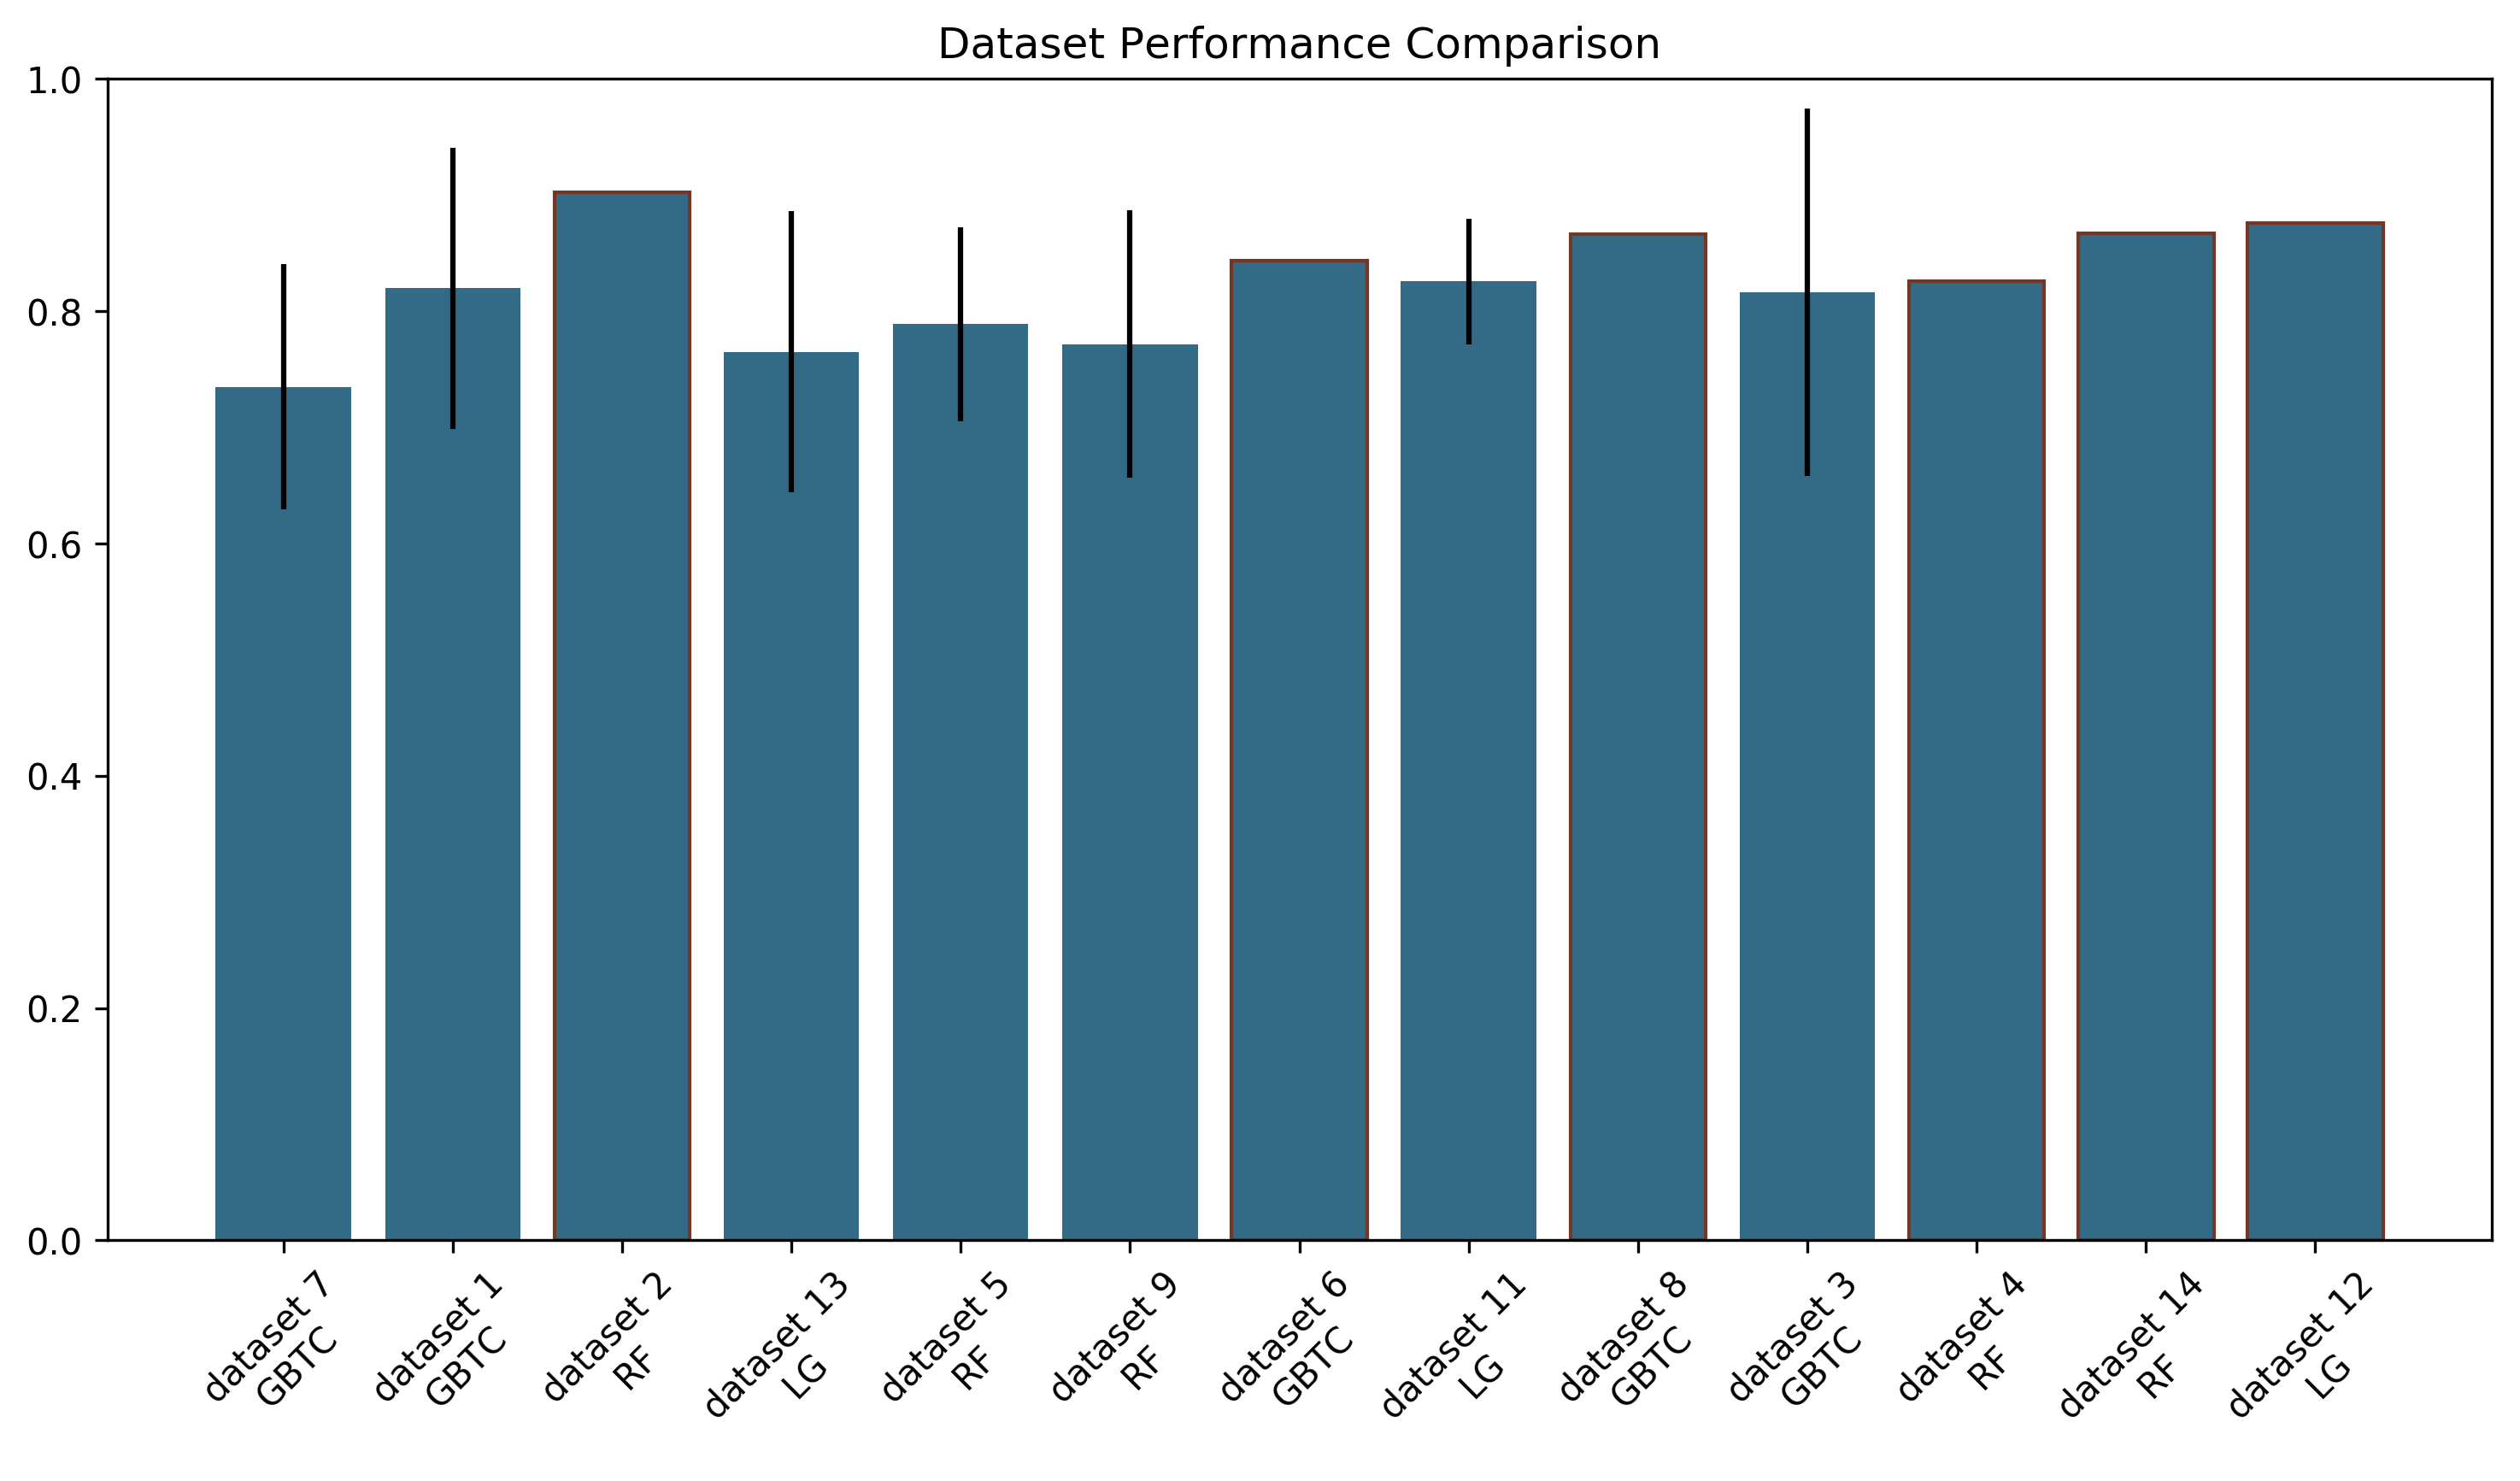

In [8]:
datasetBestModelDict = plotDatasetModelComparison(allDataModelDict = modelDictHolder,
                           dataSetComparisonList = list(allDataModelDict.keys()),
                               compMetric = "roc_auc", removeZeroF1Score = True)

Dataset with all zero f1 scores are being removed from plots
{'dataset_11_': ('logistic', 0.82570170327321579, 0.054070431583182747), 'dataset_12_': ('logistic', 0.87585499316005477, 0.0)}


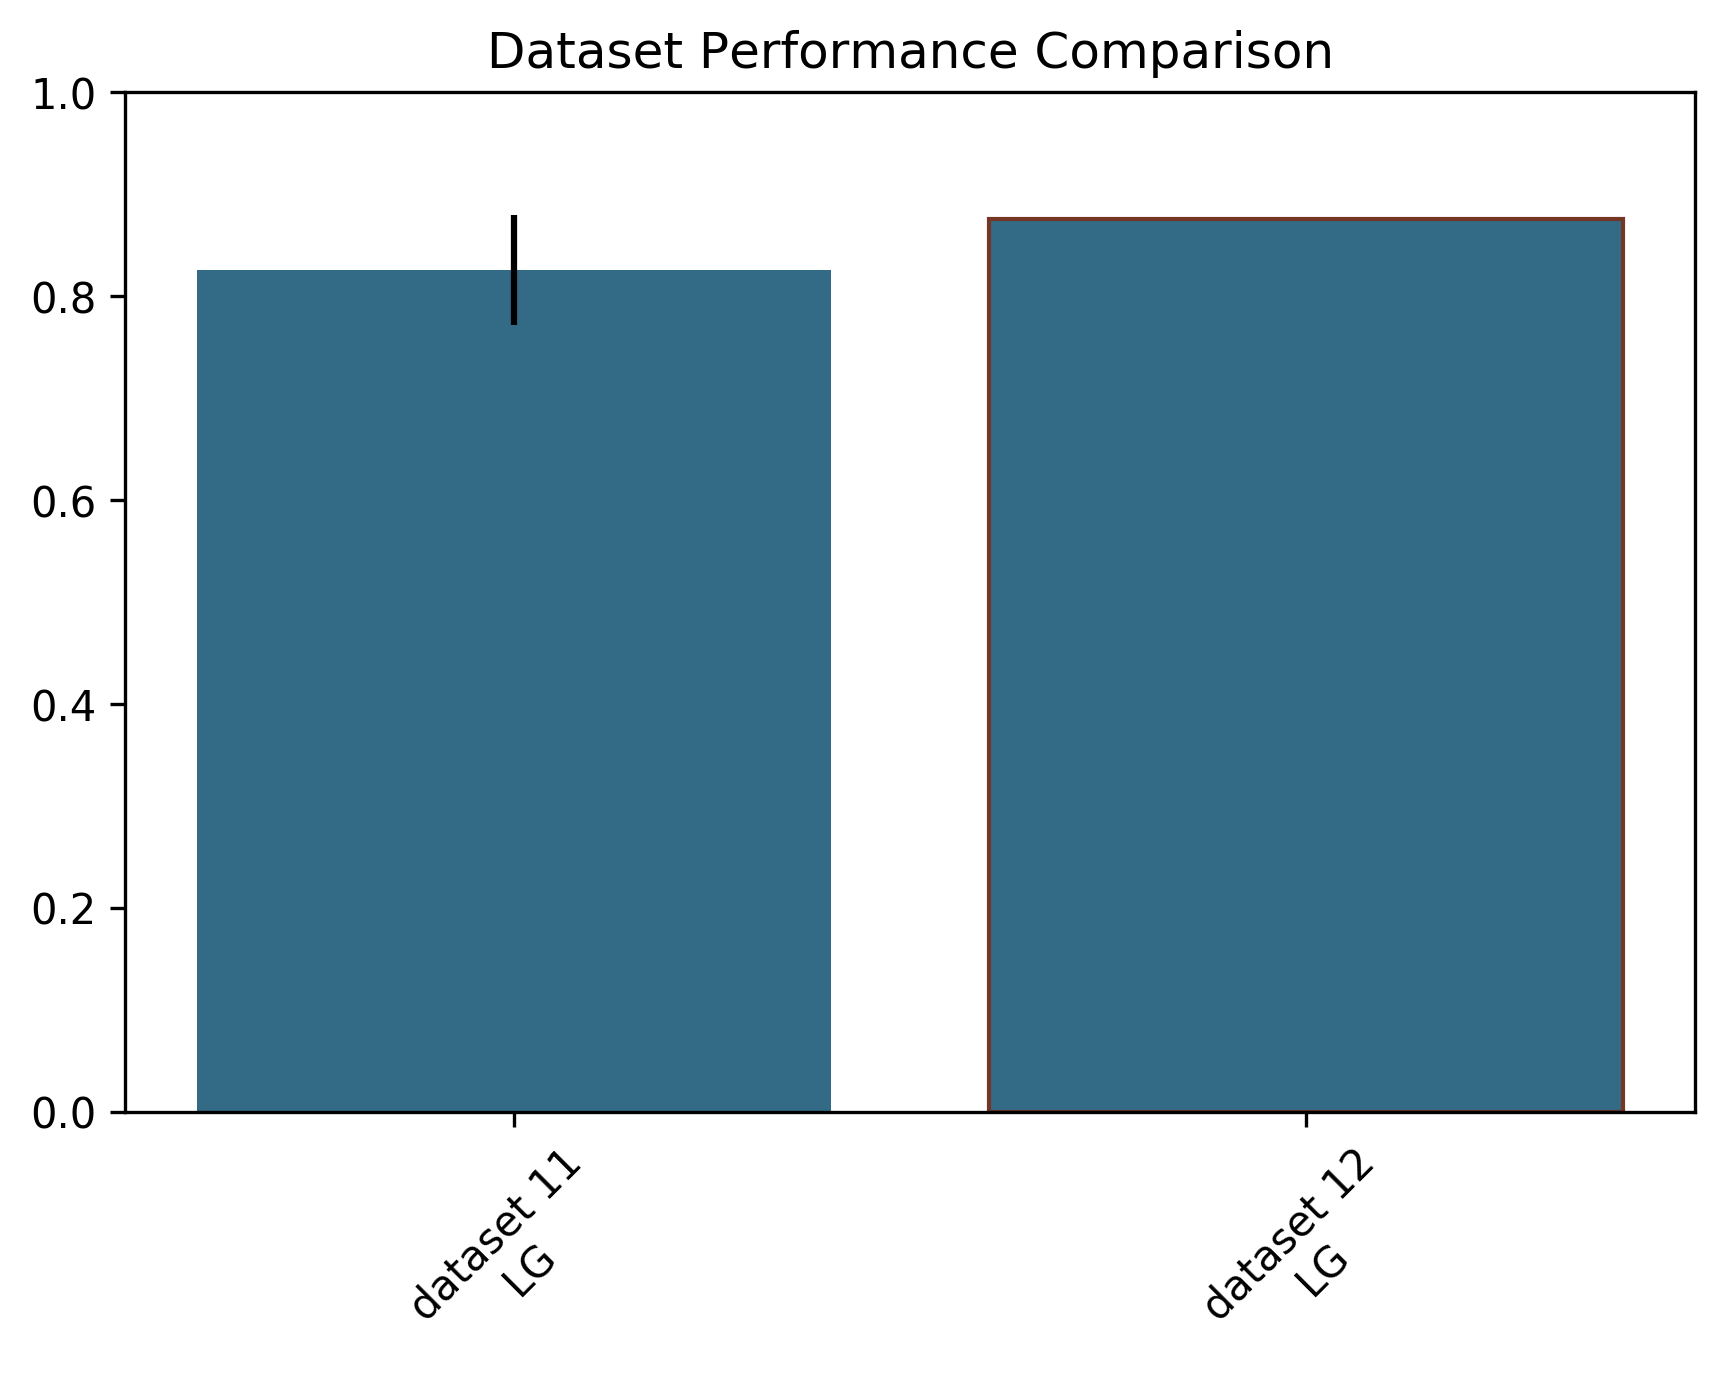

In [142]:
datasetBestModelDict = plotDatasetModelComparison(allDataModelDict = modelDictHolder,
                           dataSetComparisonList = ["dataset_11_", "dataset_12_"],
                               compMetric = "roc_auc", removeZeroF1Score = True)
print(datasetBestModelDict)

## Inspecting Dataset 12's best model


In [176]:
modelName = "logistic"
modelDict = modelDictHolder["dataset_12_"][modelName]
dataPath = "data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv"
# modelDict = modelDictAll["GBTC"]
bestModel = modelDict["gridcv"].best_estimator_
bestModel = modelDict["gridcv"].best_estimator_
featureTransformer = bestModel.steps[0][1]
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
allFeatureNames = np.array(list(X_df))
chosenFeatures = allFeatureNames[[featureTransformer.transform(np.arange(X.shape[1]).reshape([1, X.shape[1]]))]]
chosenFeatures = chosenFeatures[0]



print("feature importance for GBTC")
bestModelParams = bestModel.get_params()[modelName]
# print(bestModelParams_GBTC.feature_importances_)
if modelName == "GBTC":
    print("{} features passed to this model".format(len(bestModelParams.feature_importances_))) # for GBTC
    print("{} features given feature importance above 0\n".format(sum(bestModelParams.feature_importances_ > 0)))
    featureImportance = bestModelParams.feature_importances_
elif modelName == "logistic":
    print("{} features passed to this model".format(len(bestModelParams.coef_))) # for ligistic
    print("{} features given feature importance above 0\n".format(sum(bestModelParams.coef_ > 0)))
    featureImportance = bestModelParams.coef_[0]
featureImportance = np.abs(featureImportance)
importanceOrder = np.argsort(featureImportance)[::-1]
featureImportance = featureImportance[importanceOrder]

chosenFeatures = chosenFeatures[importanceOrder]

for feature, importanceMeasure in zip(chosenFeatures, featureImportance):
    print("Feature {} has absolute importance {}\n".format(feature, importanceMeasure))


# print("featureName,importanceMetric")
# for feature, importanceMeasure in zip(chosenFeatures, featureImportance):
#     print("{},{}".format(feature, importanceMeasure))


feature importance for GBTC
1 features passed to this model
[0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1] features given feature importance above 0

Feature KP0228_03718 has absolute importance 4.282781739792756

Feature KP0228_04626 has absolute importance 3.667042344310688

Feature KP0228_02747 has absolute importance 3.1799640829018374

Feature KP0228_03719 has absolute importance 2.673367305135039

Feature KP0228_00231 has absolute importance 2.451140910693596

Feature mgrB has absolute importance 2.1811507134972596

Feature KP0228_00418 has absolute importance 1.5549968267551526

Feature KP0228_02559 has absolute importance 1.4672611568568525

Feature KP0228_04079 has absolute importance 1.1885067001775578

Feature KP0228_01560 has absolute importance 1.14723289540869

## Get confusion matrices
Right now models are refit on the entire dataset so you need to handle that 

In [231]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
import copy
valDF = pd.read_csv("data/MLData/pbr_ml_project _datasets_20180423/dataset_12_test.csv")
valDF = valDF.set_index("isolate")
X_df = valDF.drop(labels = ["pbr_res"], axis = 1)
X_val = X_df.values
Y_df = valDF["pbr_res"]
Y_val = Y_df.values 

trainDF = pd.read_csv("data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv")
trainDF = trainDF.set_index("isolate")
X_df = trainDF.drop(labels = ["pbr_res"], axis = 1)
X_train = X_df.values
Y_df = trainDF["pbr_res"]
Y_train = Y_df.values 

bestEstimatorRefit = copy.deepcopy(modelDict["gridcv"].best_estimator_)
bestEstimatorRefit.fit(X_train, Y_train)
preds = bestEstimatorRefit.predict(X_val)
scores = bestEstimatorRefit.predict_proba(X_val)
rocauc = roc_auc_score(y_true = Y_val, y_score = scores[:,1])
f1 = f1_score(y_true = Y_val, y_pred = preds)
prec = precision_score(y_true = Y_val, y_pred = preds)
rec = recall_score(y_true = Y_val, y_pred = preds)
print("rocauc: {}".format(rocauc))
print("f1: {}".format(f1))
print("prec: {}".format(prec))
print("rec: {}".format(rec))
print("confuysion matrix. rtuth by prediction")
print(confusion_matrix(y_true = Y_val, y_pred = preds))
# truth by prediction

rocauc: 0.8751709986320109
f1: 0.8115942028985507
prec: 0.8
rec: 0.8235294117647058
confuysion matrix. rtuth by prediction
[[36  7]
 [ 6 28]]


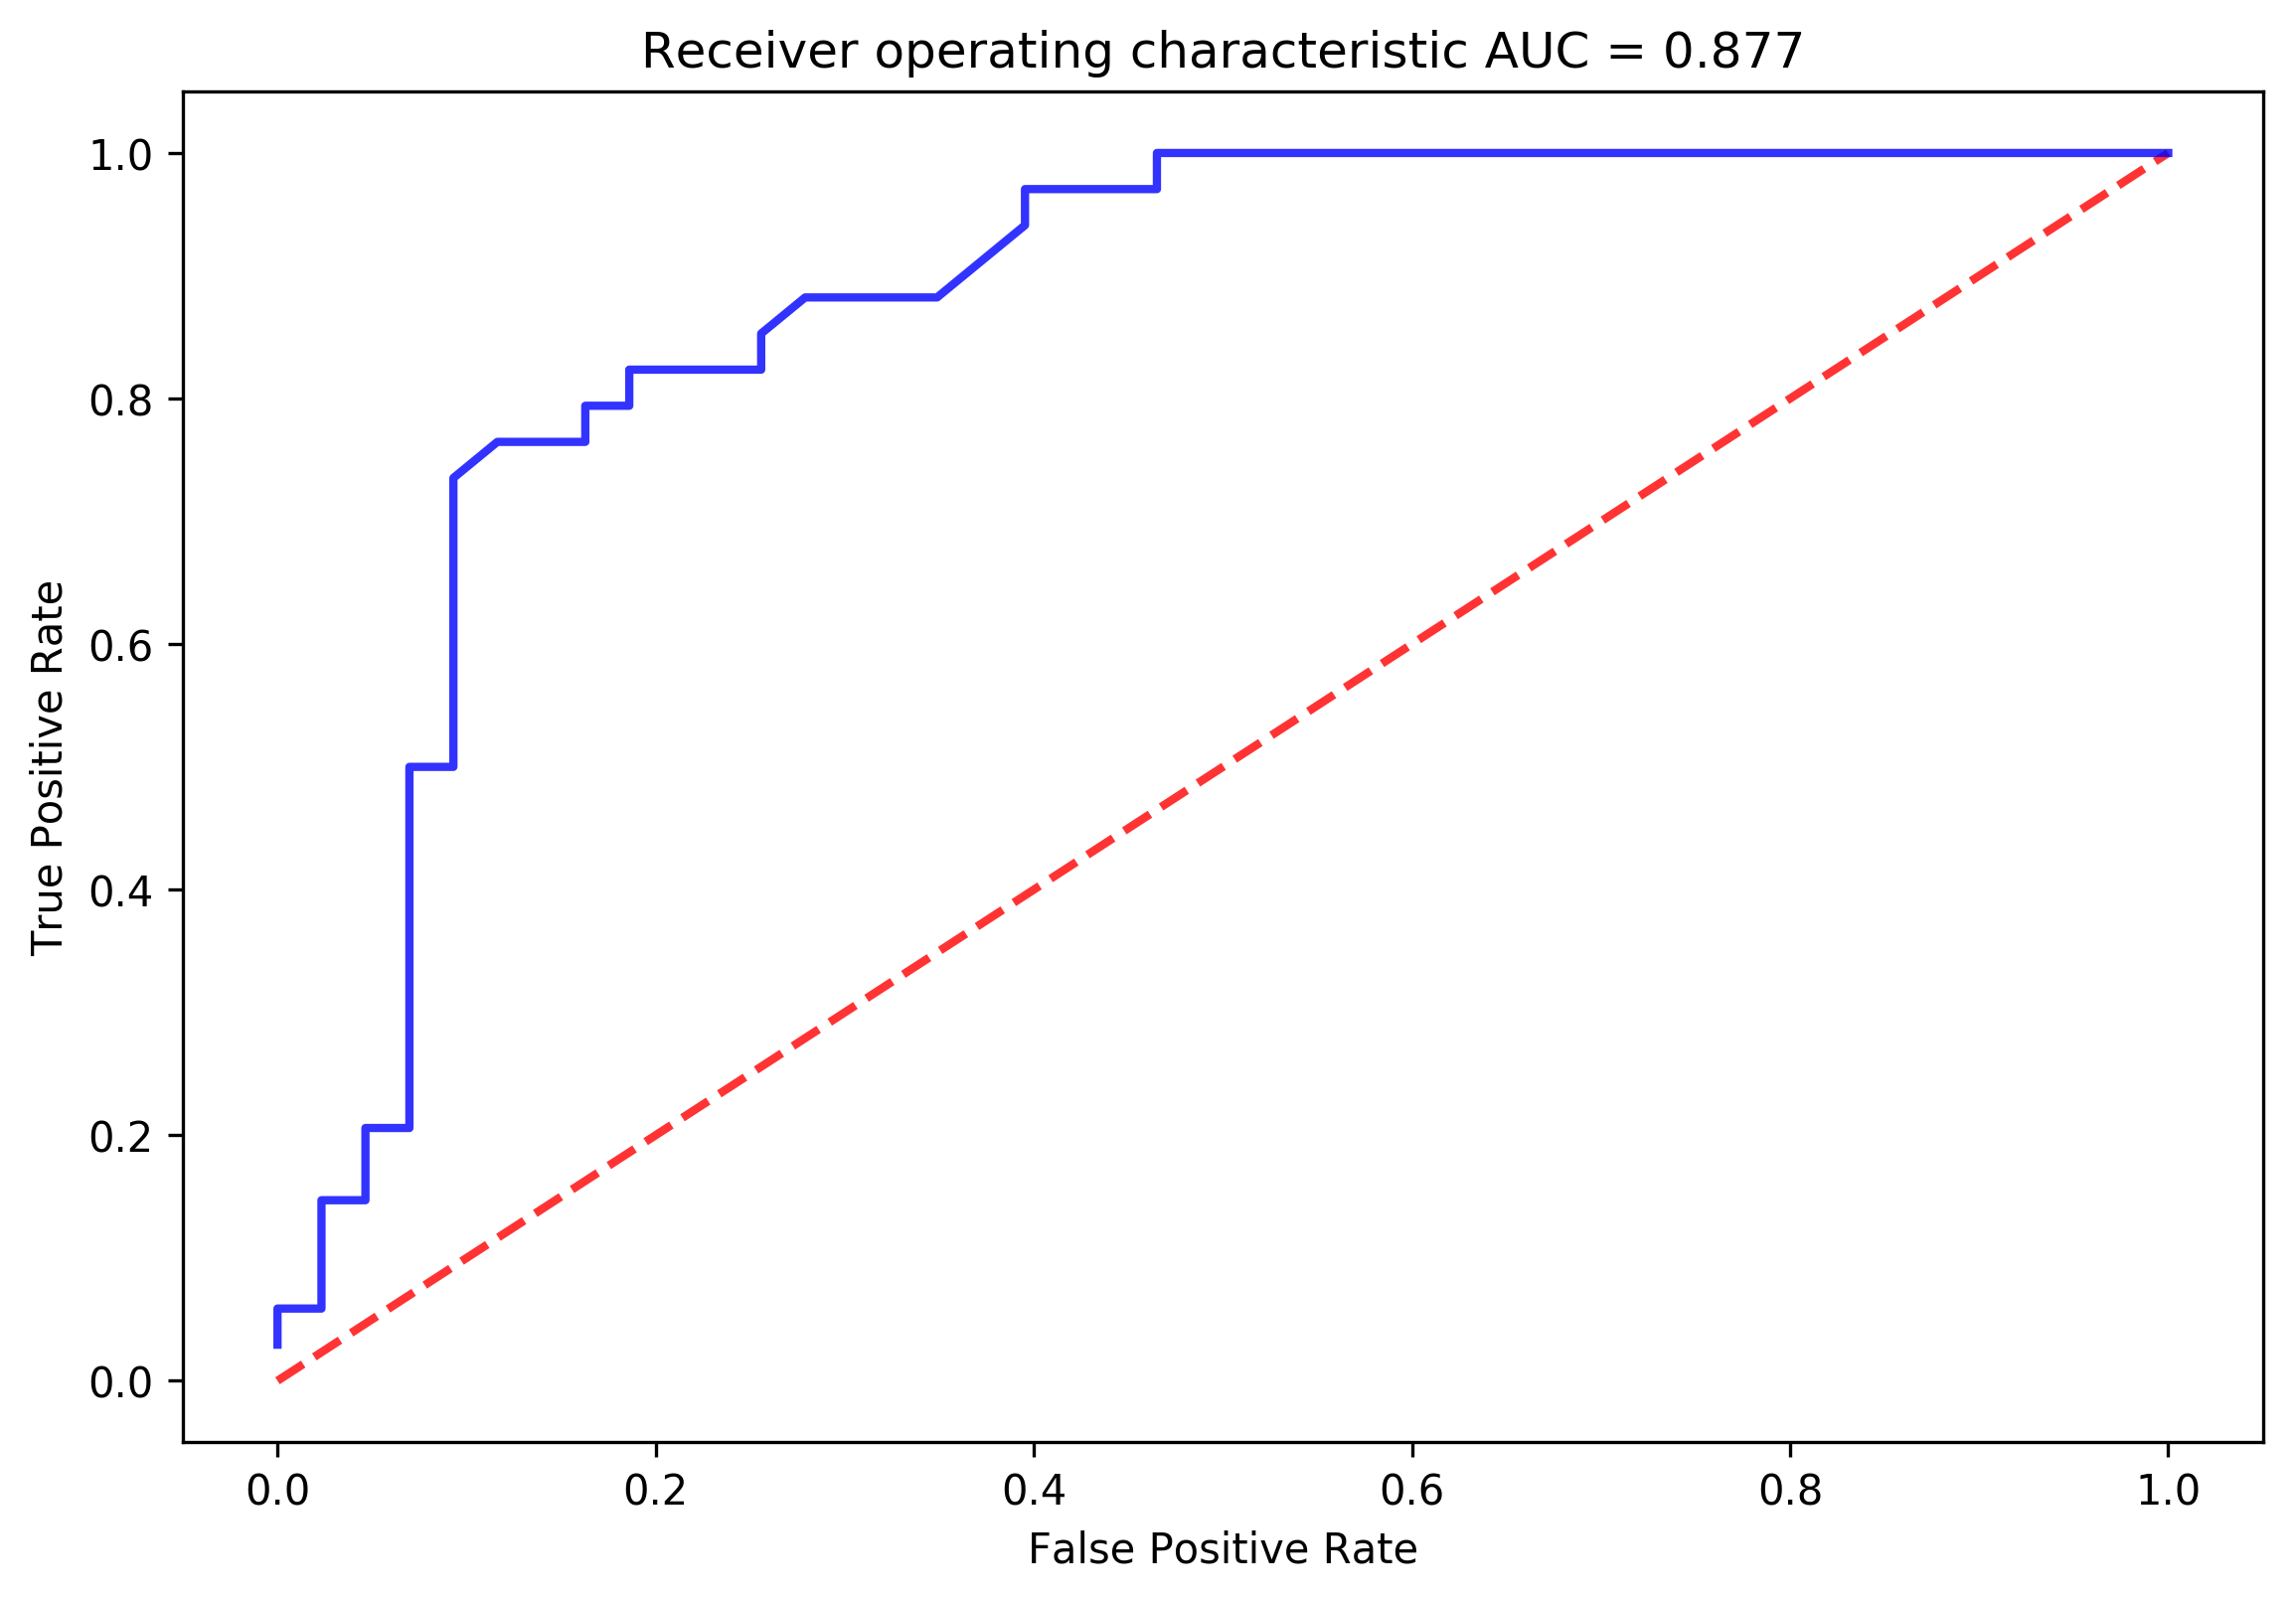

In [239]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
fig=plt.figure(figsize=(9, 6), dpi= 300, facecolor='w', edgecolor='k')
probas_ = bestEstimatorRefit.fit(X_train, Y_train).predict_proba(X_val)
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(Y_val, probas_[:, 1])
auc = roc_auc_score(Y_val, probas_[:, 1])
auc = np.round(auc, decimals = 3)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

plt.plot(fpr, tpr, color='b',
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic AUC = {}'.format(auc))
fig.savefig("plots/AUC_bestModel_holdOut.png")


In [11]:
trainDF = pd.read_csv("data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv")
# print(trainDF.shape)
valDF = pd.read_csv("data/MLData/pbr_ml_project _datasets_20180423/dataset_12_test.csv")
# print(valDF.shape)
allData = pd.concat([trainDF, valDF])

# df = pd.read_csv("data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv")
allData = allData.set_index("isolate")
X_df = allData.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = allData["pbr_res"]
Y = Y_df.values

In [12]:
X.shape

(308, 2229)

In [13]:
Y.shape

(308,)

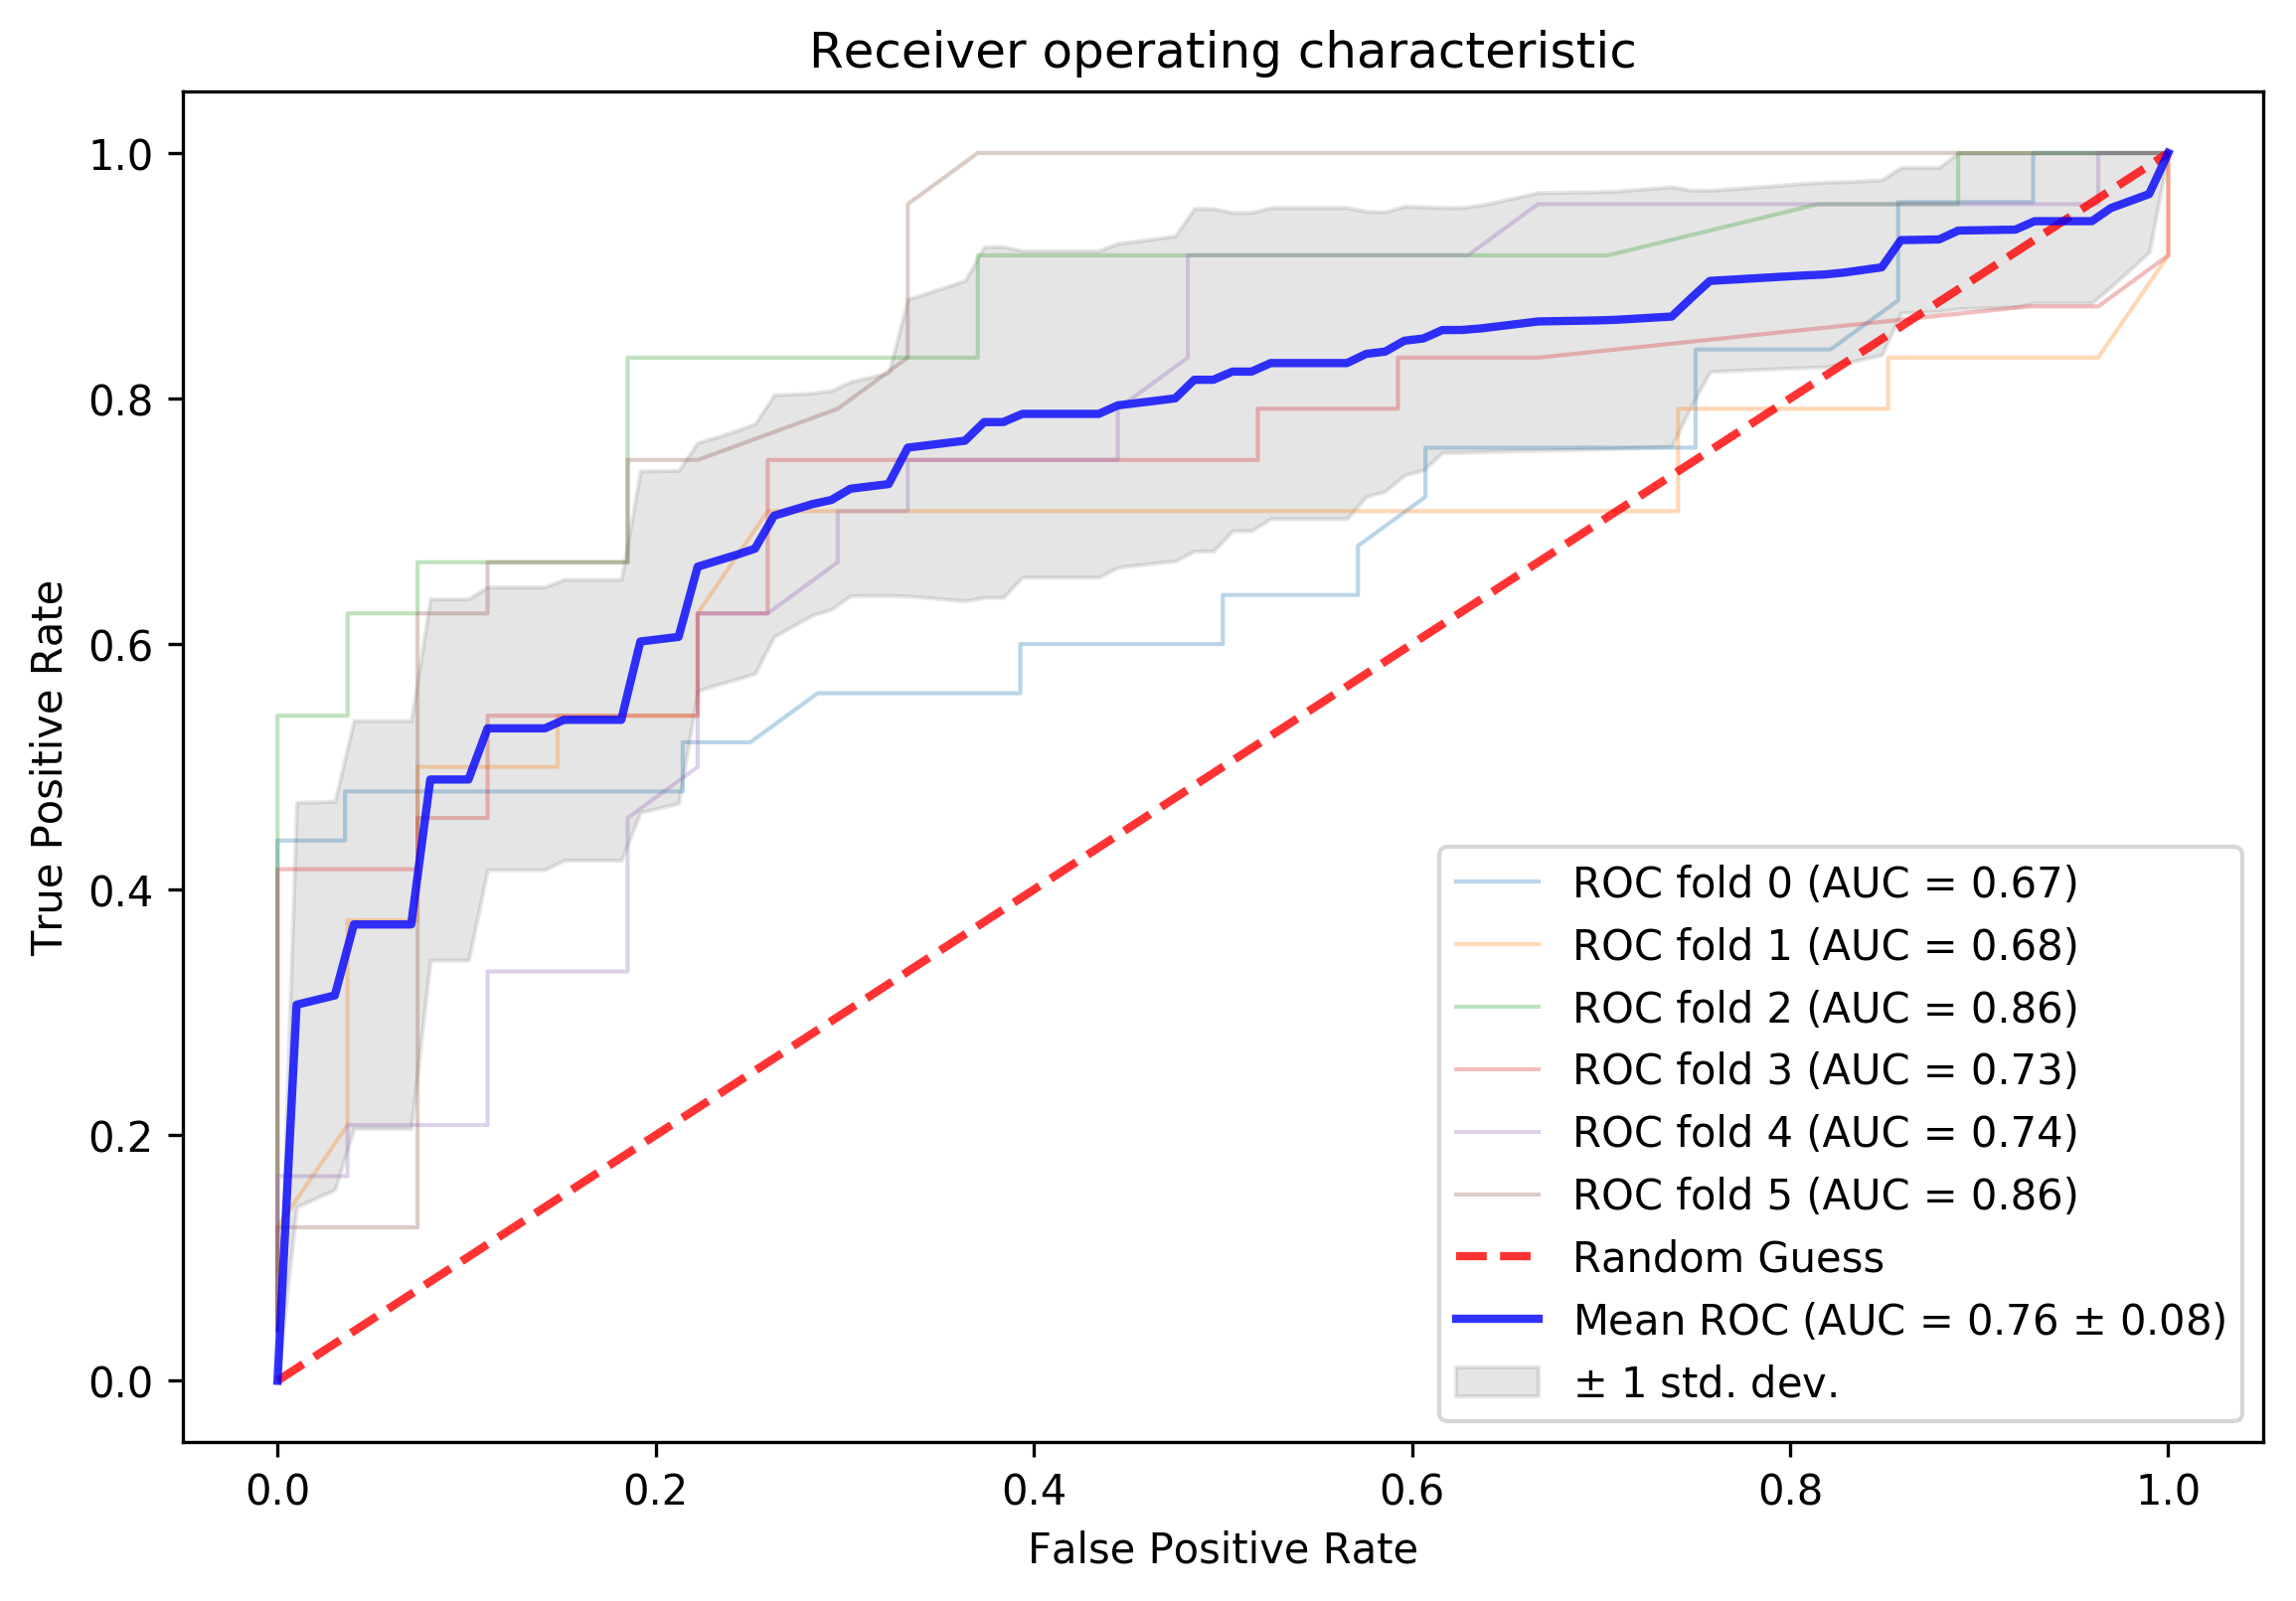

In [252]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
cv = StratifiedKFold(n_splits=6)
# classifier = svm.SVC(kernel='linear', probability=True,
#                      random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
fig=plt.figure(figsize=(9, 6), dpi= 300, facecolor='w', edgecolor='k')
for train, test in cv.split(X, Y):
    probas_ = bestEstimatorRefit.fit(X[train], Y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random Guess', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.show()
fig.savefig("plots/AUC_bestModel_CV.png")

In [66]:
# modelDictAll = modelDict
# modelDictPicklePath = "data/modelDictMultiDataRun.pkl"
# with open(modelDictPicklePath, "wb") as pklFile:
#     pickle.dump(modelDictHolder, pklFile)


In [ ]:
# modelDictPicklePath = "data/modelDict.pkl"

# with open(modelDictPicklePath, "rb") as pklFile:
#     modelDictAll = pickle.load(pklFile)

f1
[ 0.773  0.776  0.796  0.771]
[ 0.103  0.106  0.094  0.048]
recall
[ 0.759  0.793  0.871  0.948]
[ 0.141  0.151  0.132  0.086]
precision
[ 0.807  0.771  0.739  0.652]
[ 0.128  0.066  0.086  0.043]


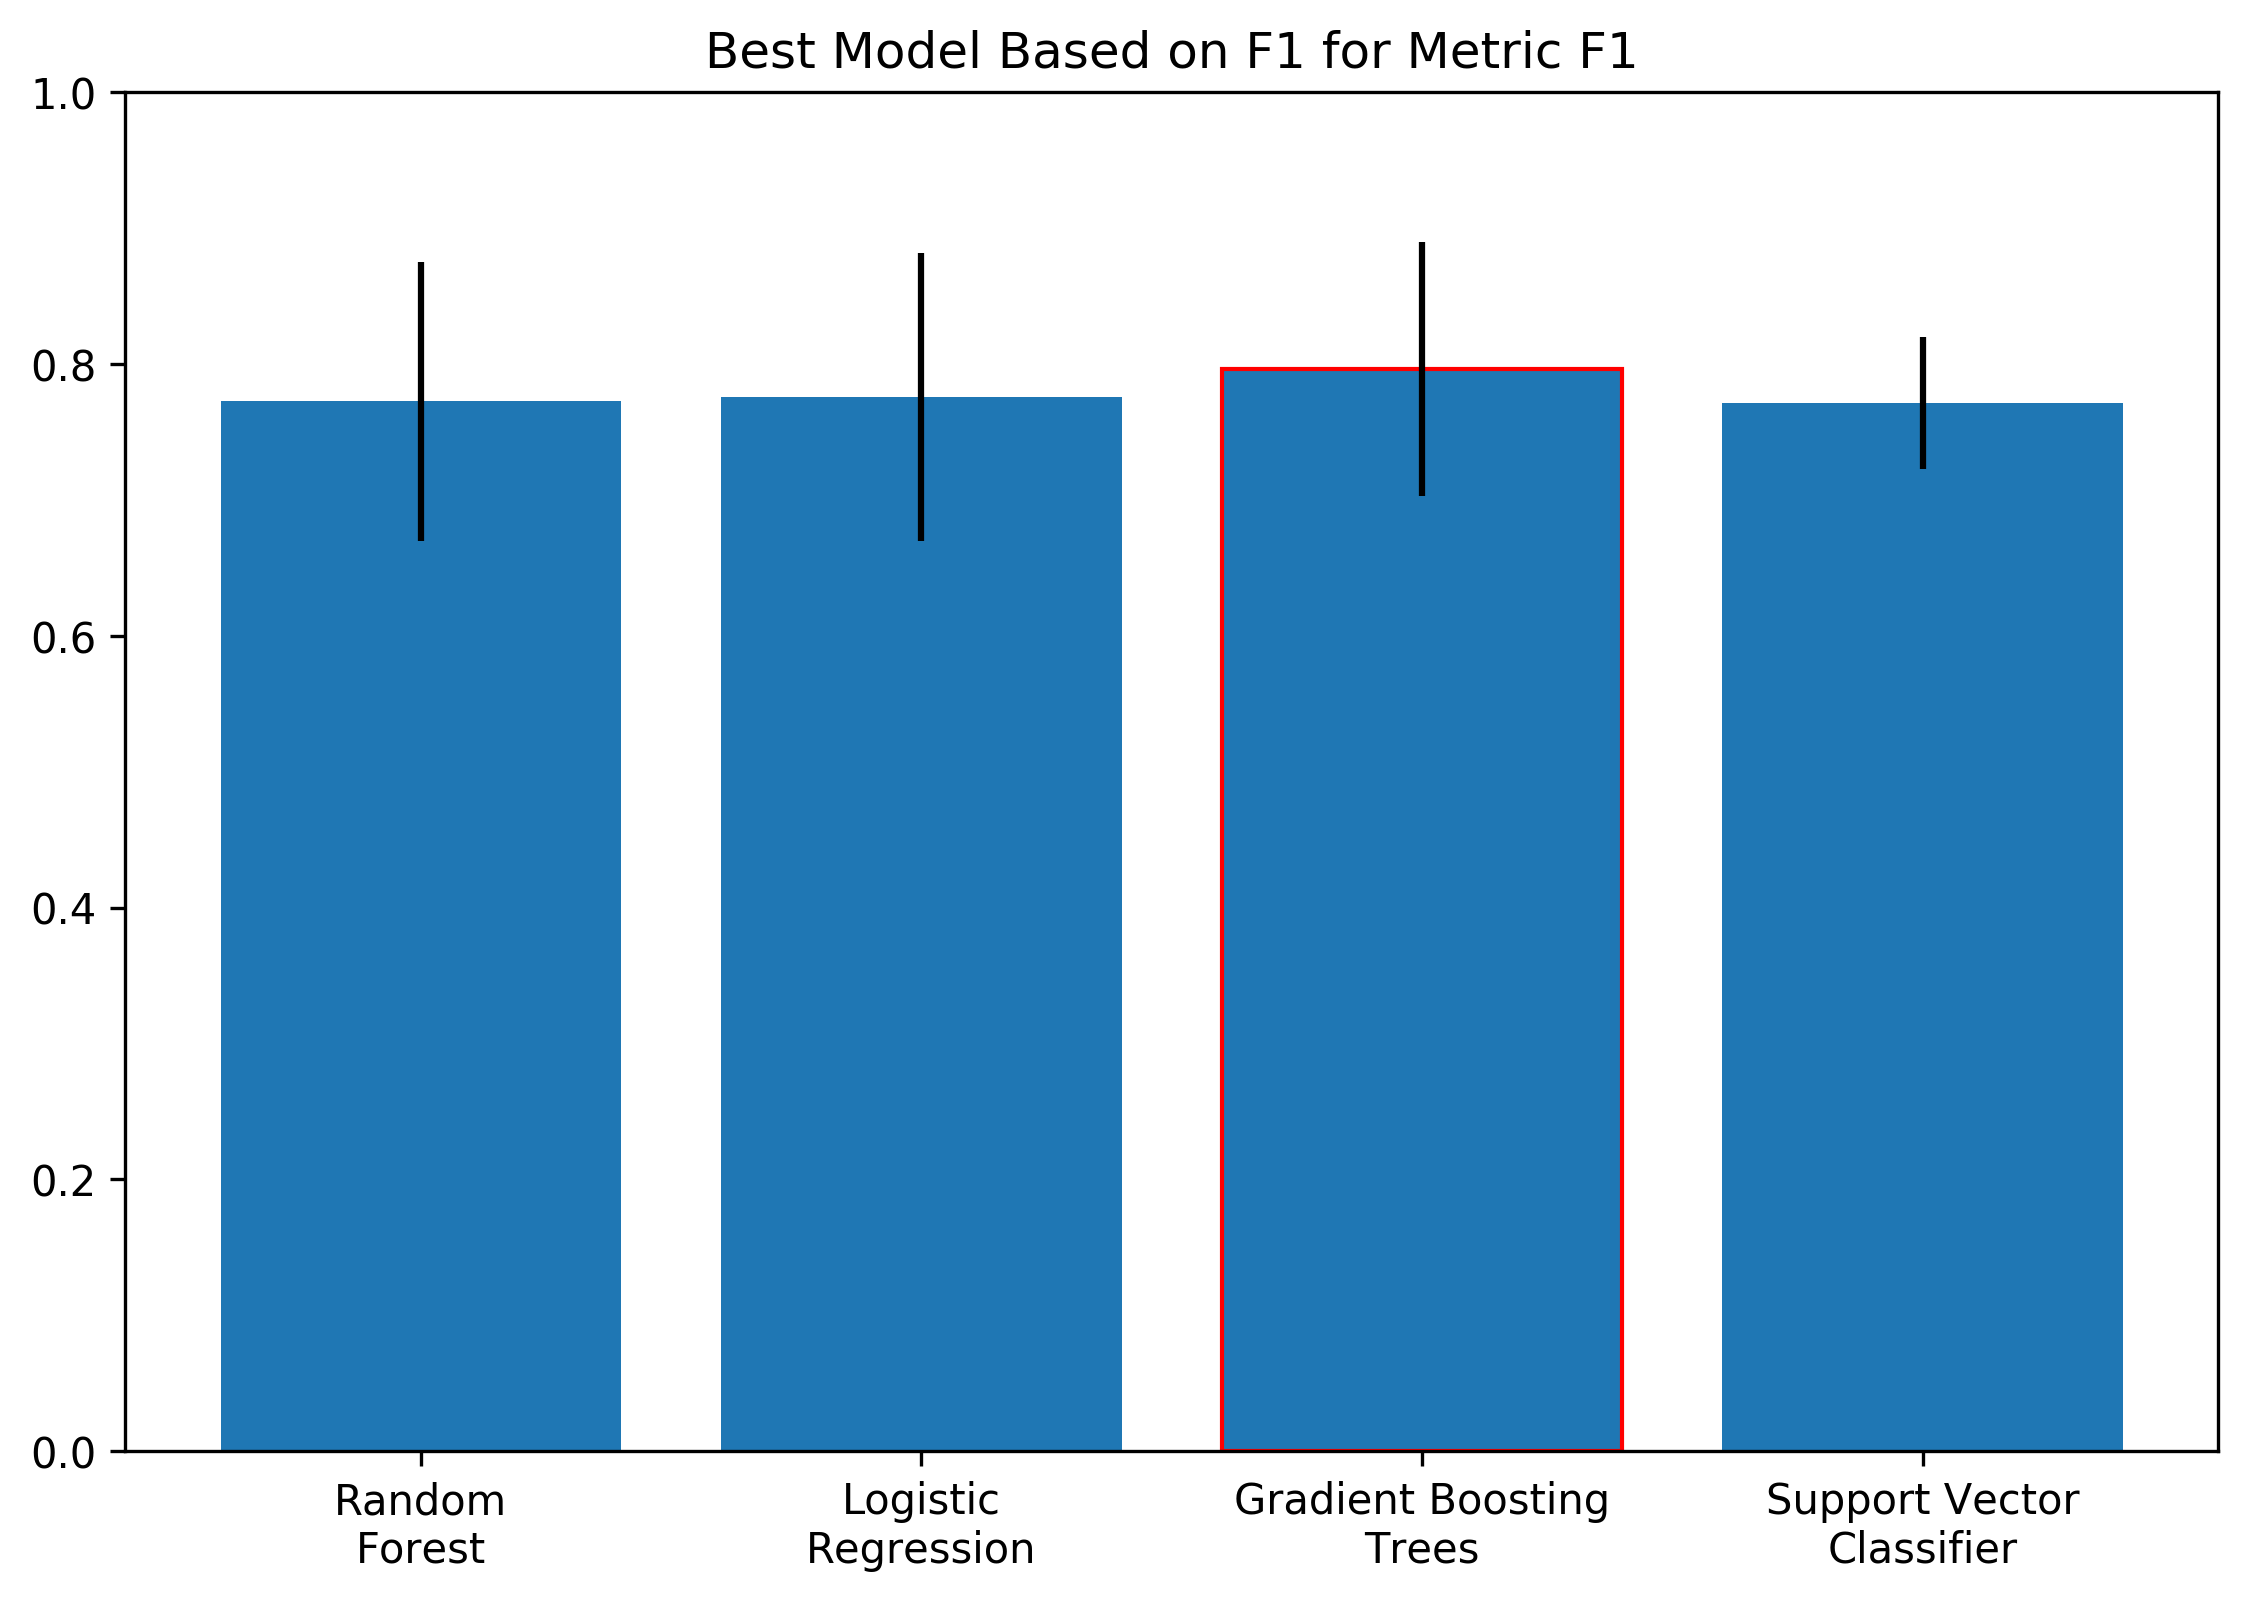

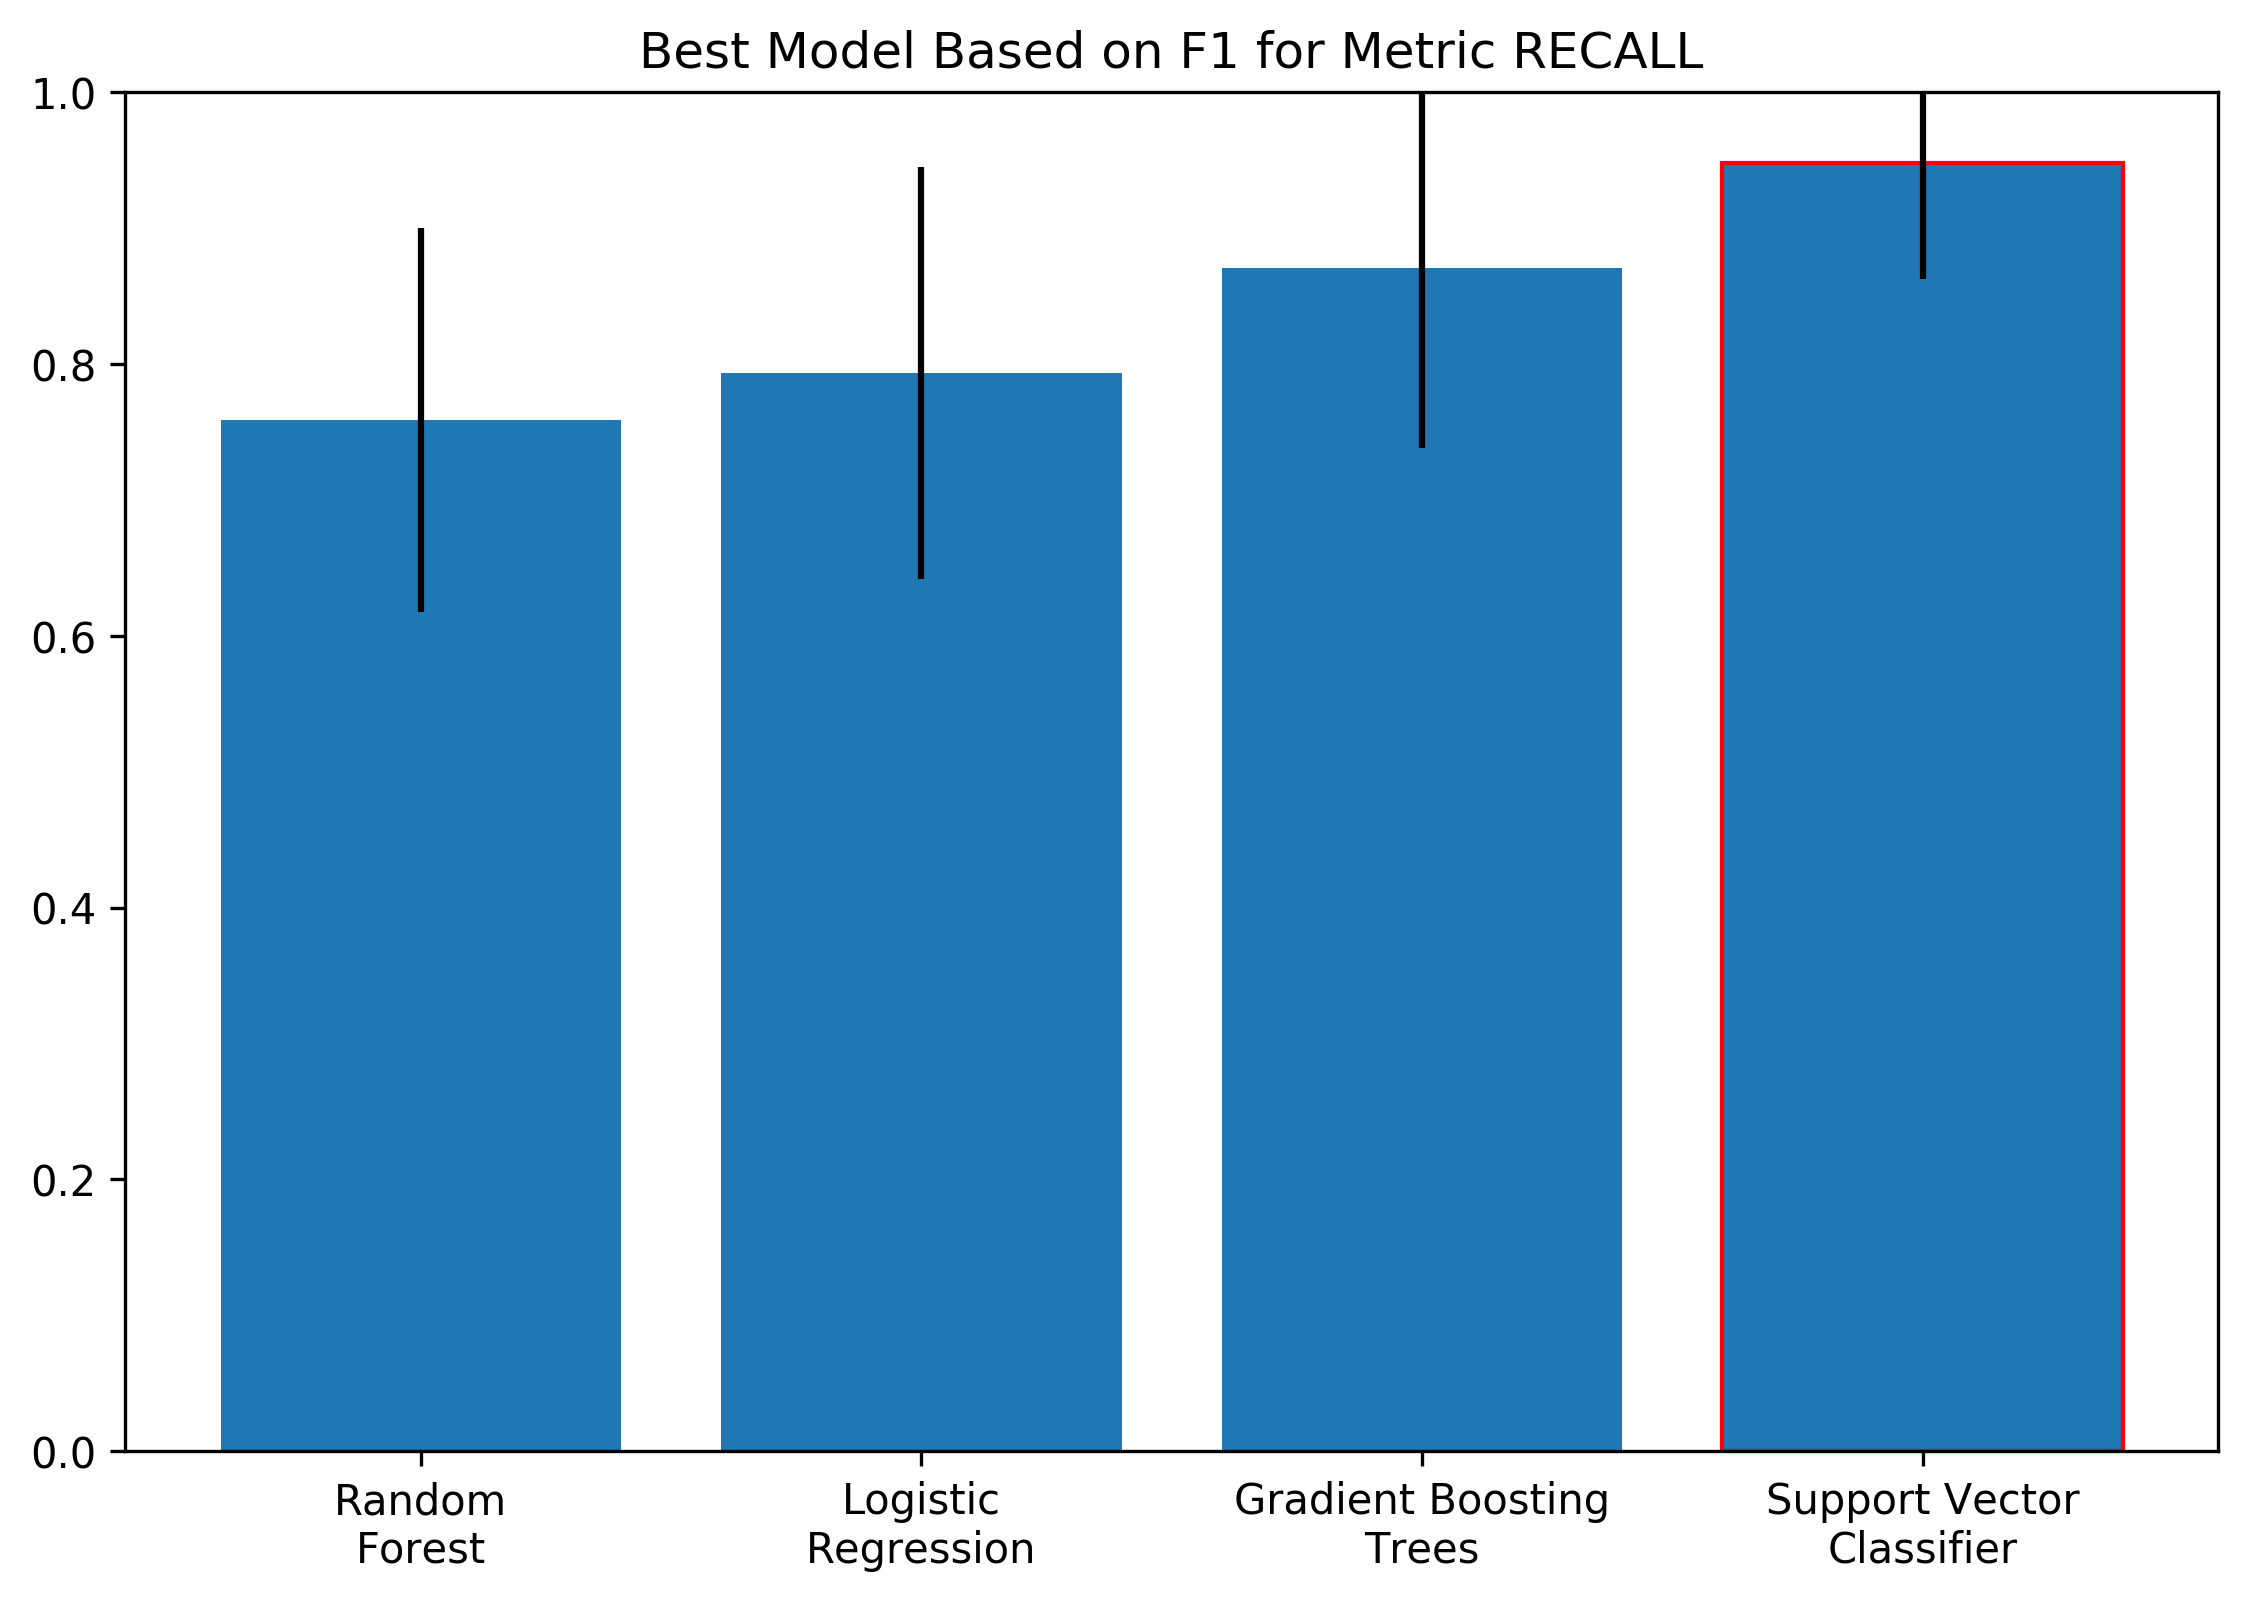

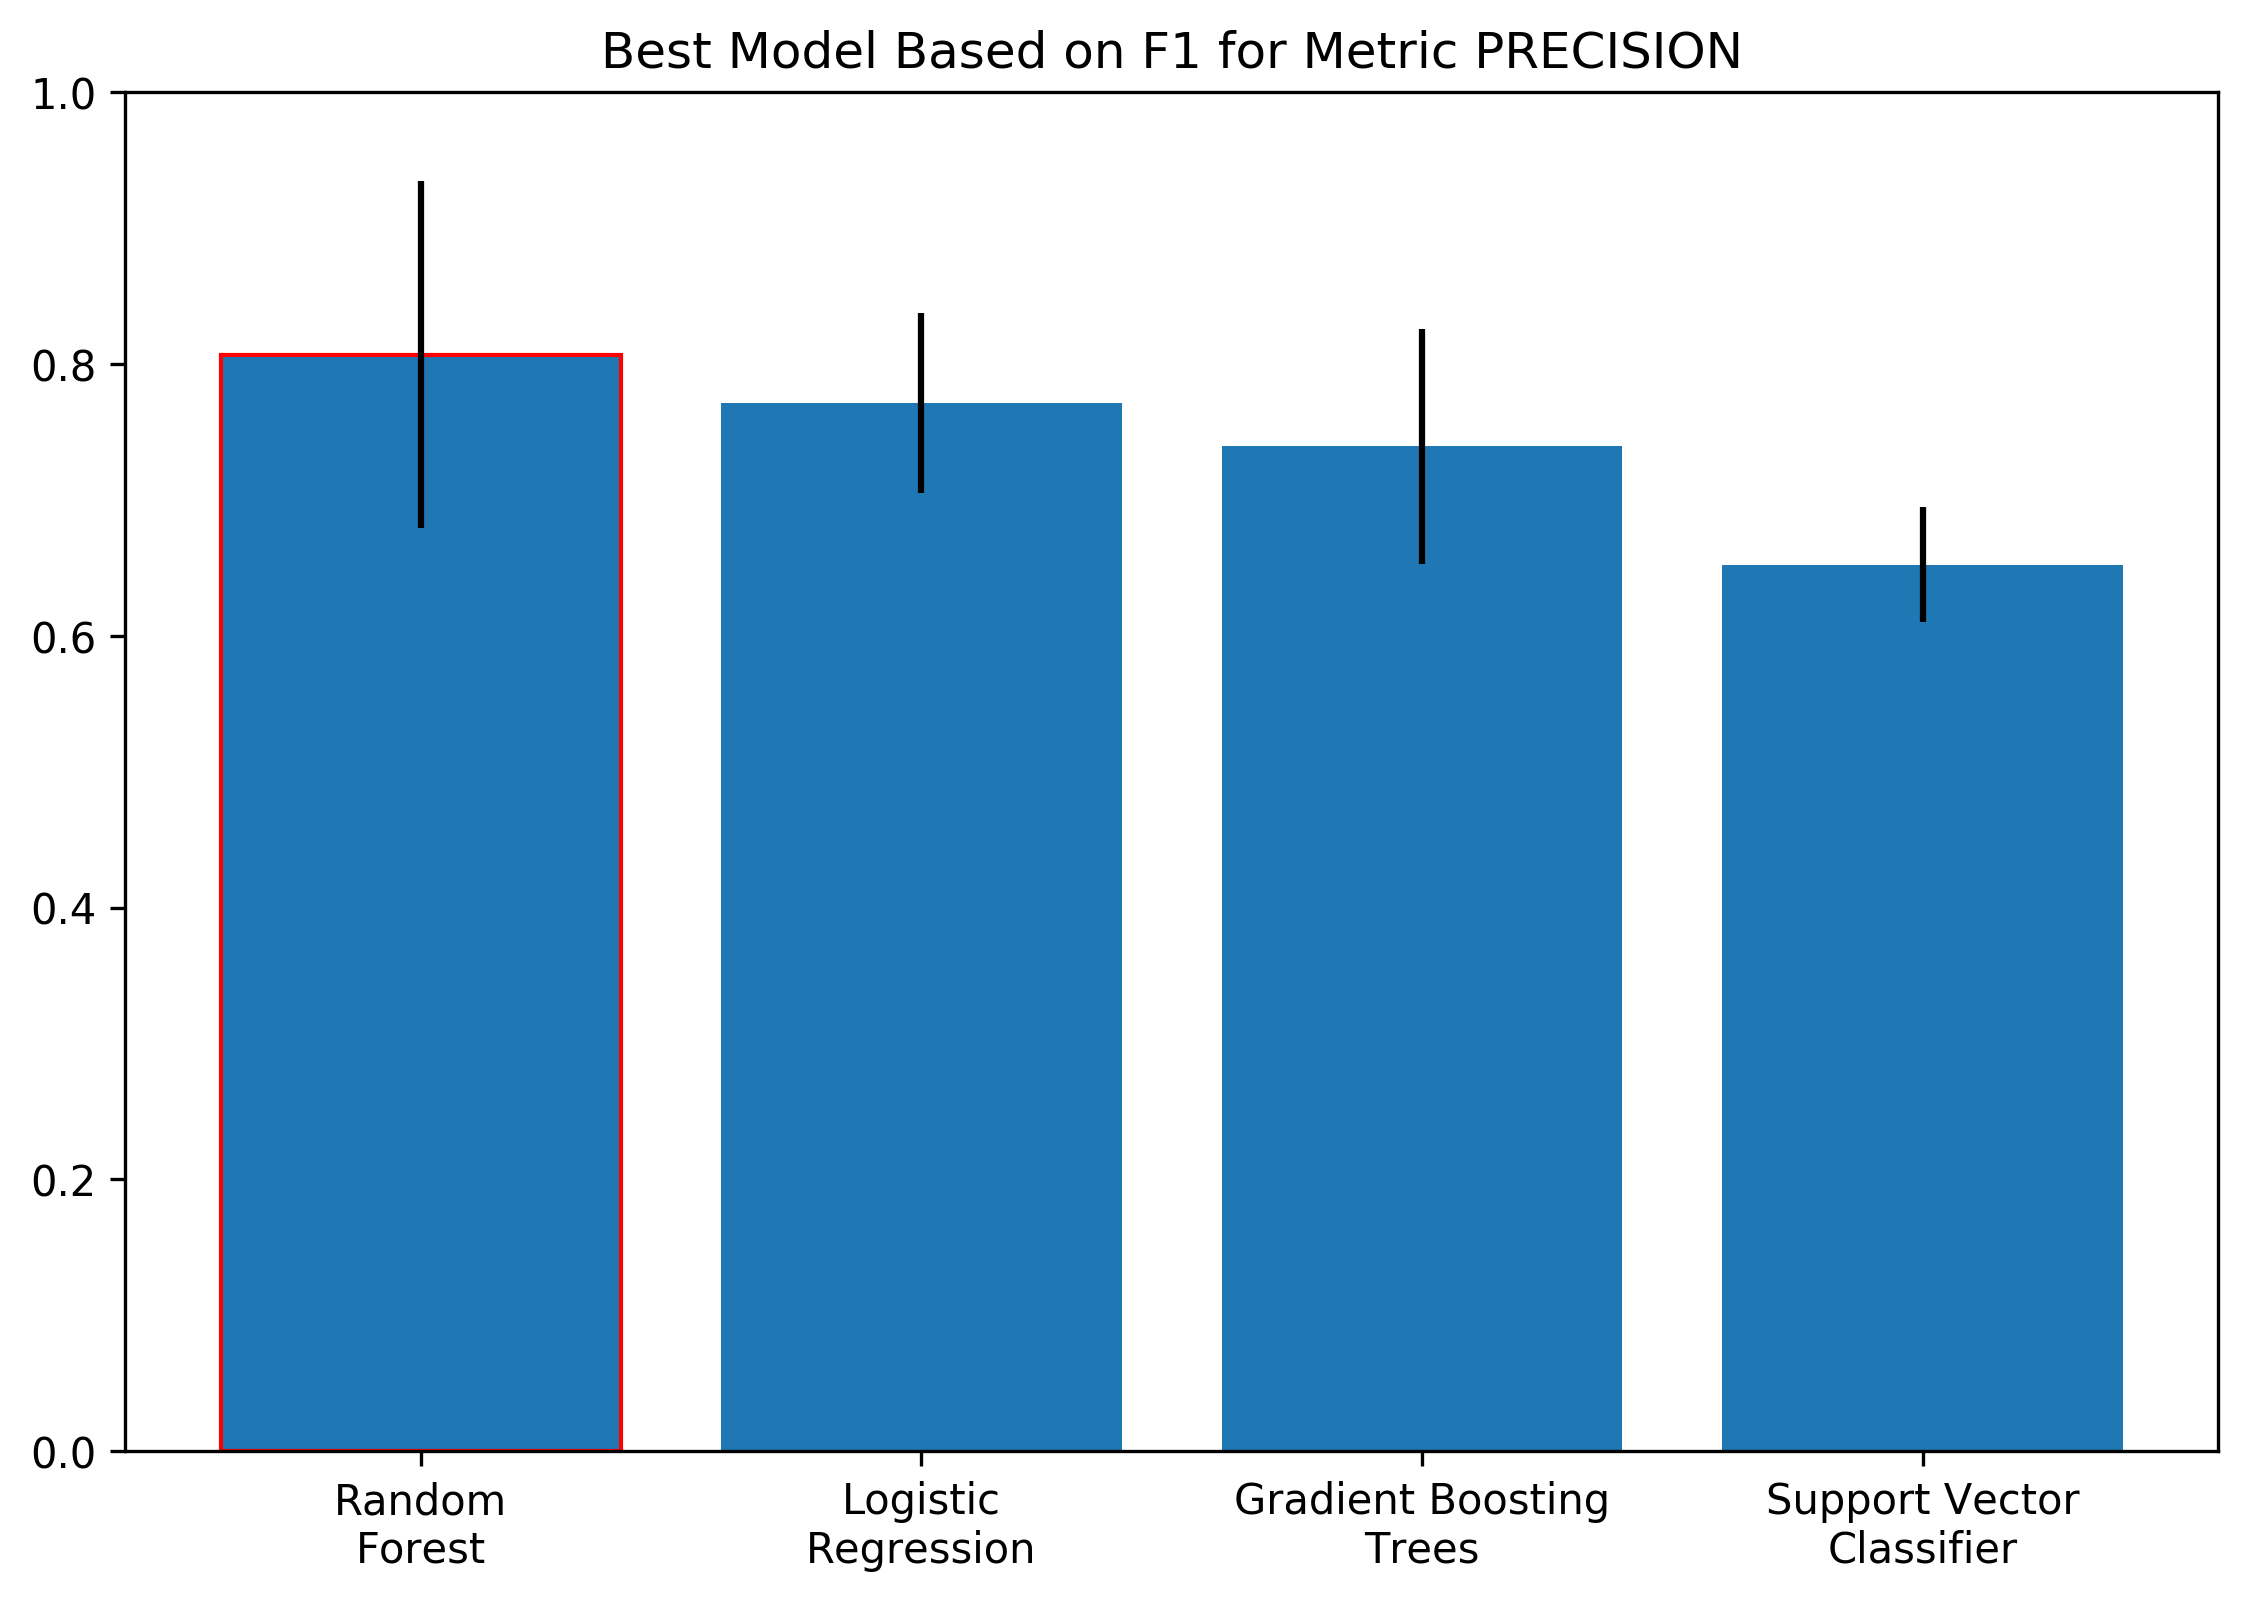

In [32]:
scoringDict = plotBestModelComparison(modelDictAll)

In [10]:
scoringDict

defaultdict(<function src.mlPipeline.plotting.plotBestModelComparison.<locals>.<lambda>>,
            {'GBTC': defaultdict(float,
                         {'f1_mean': 0.79327913770662095,
                          'f1_std': 0.092425053342588825,
                          'precision_mean': 0.7349237153715763,
                          'precision_std': 0.087682690319751788,
                          'recall_mean': 0.87071472298745012,
                          'recall_std': 0.13241676423730606}),
             'SVC': defaultdict(float,
                         {'f1_mean': 0.77132786739757431,
                          'f1_std': 0.048393165918264064,
                          'precision_mean': 0.652486683136838,
                          'precision_std': 0.042508695852810793,
                          'recall_mean': 0.9482323232323232,
                          'recall_std': 0.085533028052727}),
             'logistic': defaultdict(float,
                         {'f1_mean': 0.760770703843

# Permutation Test
After the best model has been chosen we need to see if our model is truly picking up on signal. To do this we can permute the labels, and re-estimate the CV error for the best model's parameters.

In [90]:
from time import time
start = time()

In [99]:
Y.mean()

0.5858585858585859

## Permutation test done with CV

In [96]:
from sklearn.model_selection import cross_val_score
from time import time
nRepeats = 500
modelDict = modelDictAll["GBTC"]
bestModel = modelDict["gridcv"].best_estimator_
scoringMetric = modelDict["refitMetric"]
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = df["pbr_res"]
Y_shuffle = np.array(Y_df.values)
Y = np.array(Y_df.values)
allScoresMeanCV_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                  dtype = float)
allScoresStdCV_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                 dtype = float)
allScoresMeanCV_true = np.full(shape = nRepeats, fill_value = -1,
                               dtype = float)
allScoresStdCV_true = np.full(shape = nRepeats, fill_value = -1,
                              dtype = float)

# YShuffle = np.random.shuffle(Y)
shuffledIdx = np.arange(Y.shape[0])


n_cv = 10

start = time()
for i in range(nRepeats):
    np.random.shuffle(shuffledIdx)
#     print(i)
    if np.mod(i, 10) == 0:
        iterTime = time() - start
        print("Running iteration {} in {} seconds".format(i, iterTime))
        start = time()
    np.random.shuffle(Y_shuffle)
    currScoresCV_shuffle = cross_val_score(estimator = bestModel, X = X, y = Y_shuffle,
                                           cv = n_cv, n_jobs = 3, verbose = 0, 
                                           scoring = scoringMetric)
    X = X[shuffledIdx, :]
    Y = Y[shuffledIdx]
    currScoresCV_true = cross_val_score(estimator = bestModel, X = X, y = Y,
                                           cv = n_cv, n_jobs = 3, verbose = 0, 
                                           scoring = scoringMetric)
    allScoresMeanCV_shuffle[i] = currScoresCV_shuffle.mean()
    allScoresStdCV_shuffle[i] = np.std(currScoresCV_shuffle)
    allScoresMeanCV_true[i] = currScoresCV_true.mean()
    allScoresStdCV_true[i] = np.std(currScoresCV_true)
#     print(allScoresMeanCV_shuffle)
#     print(allScoresMeanCV_true)
    

# take in best model
# take in data
# take in n for permutations
# take in optional test set
# take in cv if not test set.
from scipy.stats import ttest_ind
ttest_ind(a = allScoresMeanCV_shuffle,
          b = allScoresMeanCV_true)

Running iteration 0 in 0.0004374980926513672 seconds
Running iteration 10 in 142.70513892173767 seconds
Running iteration 20 in 140.95882320404053 seconds
Running iteration 30 in 142.8495650291443 seconds
Running iteration 40 in 143.63306164741516 seconds
Running iteration 50 in 149.58917498588562 seconds
Running iteration 60 in 143.65398240089417 seconds
Running iteration 70 in 145.91169714927673 seconds
Running iteration 80 in 142.4729940891266 seconds
Running iteration 90 in 139.5033118724823 seconds
Running iteration 100 in 142.23135137557983 seconds
Running iteration 110 in 141.36219310760498 seconds
Running iteration 120 in 142.11380338668823 seconds
Running iteration 130 in 141.0321683883667 seconds
Running iteration 140 in 141.4959008693695 seconds
Running iteration 150 in 145.7419421672821 seconds
Running iteration 160 in 143.68236231803894 seconds
Running iteration 170 in 141.1173813343048 seconds
Running iteration 180 in 141.3674533367157 seconds
Running iteration 190 in 137

Ttest_indResult(statistic=-81.82435501231497, pvalue=0.0)

## Permutation test done with heldout dataset

In [5]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, confusion_matrix
trainPath = "data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv"
valPath = "data/MLData/pbr_ml_project _datasets_20180423/dataset_12_test.csv"

print("Using trainFile: {}\nvalFile: {}".format(trainPath, valPath))
trainDF = pd.read_csv(trainPath)
print(trainDF.shape)
valDF = pd.read_csv(valPath)
print(valDF.shape)


valDF = valDF.set_index("isolate")
X_df = valDF.drop(labels = ["pbr_res"], axis = 1)
X_val = X_df.values
Y_df = valDF["pbr_res"]
Y_val = Y_df.values 

trainDF = trainDF.set_index("isolate")
X_df = trainDF.drop(labels = ["pbr_res"], axis = 1)
X_train = X_df.values
Y_df = trainDF["pbr_res"]
Y_train = Y_df.values 
Y_train_shuffle = np.array(Y_df.values)

Using trainFile: data/MLData/pbr_ml_project _datasets_20180423/dataset_12_train.csv
valFile: data/MLData/pbr_ml_project _datasets_20180423/dataset_12_test.csv
(231, 2231)
(77, 2231)


In [11]:
modelName = "logistic"
modelDict = allDataModelDict["dataset_12_"][modelName]
bestModel = copy.deepcopy(modelDict["gridcv"].best_estimator_)

In [16]:
from sklearn.model_selection import cross_val_score
from time import time


def getMetrics(probs, preds, y):
    rocauc = roc_auc_score(y_true = y, y_score = probs)
    f1 = f1_score(y_true = y, y_pred = preds)
    prec = precision_score(y_true = y, y_pred = preds)
    rec = recall_score(y_true = y, y_pred = preds)
    return(rocauc, f1, prec, rec)
    print("rocauc: {}".format(rocauc))
    print("f1: {}".format(f1))
    print("prec: {}".format(prec))
    print("rec: {}".format(rec))
    print("confuysion matrix. rtuth by prediction")


nRepeats = 500
scoringMetric = modelDict["refitMetric"]

allF1_shuffle = np.full(shape = nRepeats, fill_value = -1,
                                  dtype = float)
allF1_true = np.full(shape = nRepeats, fill_value = -1,
                                 dtype = float)
allAUC_shuffle = np.full(shape = nRepeats, fill_value = -1,
                               dtype = float)
allAUC_true = np.full(shape = nRepeats, fill_value = -1,
                              dtype = float)

# YShuffle = np.random.shuffle(Y)
originalSampleIndex = np.arange(Y_train.shape[0])
trainingSampleSize = 200

# n_cv = 10

start = time()
for i in range(nRepeats):
    sampleIndex = np.random.choice(originalSampleIndex,
                                   size = trainingSampleSize,
                                   replace = False)
#     print(i)
    if np.mod(i, 10) == 0:
        iterTime = time() - start
        print("Running iteration {} in {} seconds".format(i, iterTime))
        start = time()
    np.random.shuffle(Y_train_shuffle)
    bestModel.fit(X_train, Y_train_shuffle)
    shuffleProbs = bestModel.predict_proba(X_val)[:, 1]
    shufflePreds = bestModel.predict(X_val)
    allAUC_shuffle[i], allF1_shuffle[i], _, _, = getMetrics(probs = shuffleProbs,
                                                            preds = shufflePreds,
                                                            y = Y_val)
#     currScoresCV_shuffle = cross_val_score(estimator = bestModel, X = X, y = Y_shuffle,
#                                            cv = cv, n_jobs = 1, verbose = 0, 
#                                            scoring = scoringMetric)
#     X = X[shuffledIdx, :]
#     Y = Y[shuffledIdx]
    bestModel.fit(X_train[sampleIndex, :], Y_train[sampleIndex])
    trueProbs = bestModel.predict_proba(X_val)[:, 1]
    truePreds = bestModel.predict(X_val)
    allAUC_true[i], allF1_true[i], _, _, = getMetrics(probs = trueProbs,
                                                            preds = truePreds,
                                                            y = Y_val)
#     print(allAUC_shuffle[i])
#     print(allAUC_true[i])
#     print(allScoresMeanCV_shuffle)
#     print(allScoresMeanCV_true)
    

# take in best model
# take in data
# take in n for permutations
# take in optional test set
# take in cv if not test set.
from scipy.stats import mannwhitneyu
mannwhitneyu(x = allAUC_shuffle,
          y = allAUC_true)

Running iteration 0 in 0.0003325939178466797 seconds
Running iteration 10 in 1.3743243217468262 seconds
Running iteration 20 in 1.4126698970794678 seconds
Running iteration 30 in 1.2446925640106201 seconds
Running iteration 40 in 1.2469680309295654 seconds
Running iteration 50 in 1.445005178451538 seconds
Running iteration 60 in 1.532149076461792 seconds
Running iteration 70 in 1.445889949798584 seconds
Running iteration 80 in 1.2538790702819824 seconds
Running iteration 90 in 1.237877607345581 seconds
Running iteration 100 in 1.2599399089813232 seconds
Running iteration 110 in 1.2578270435333252 seconds
Running iteration 120 in 1.2381296157836914 seconds
Running iteration 130 in 1.222649335861206 seconds
Running iteration 140 in 1.2401618957519531 seconds
Running iteration 150 in 1.277634859085083 seconds
Running iteration 160 in 1.267657995223999 seconds
Running iteration 170 in 1.259214162826538 seconds
Running iteration 180 in 1.2652955055236816 seconds
Running iteration 190 in 1.4

MannwhitneyuResult(statistic=0.0, pvalue=2.9240514016712149e-165)

In [17]:
# print(allScoresMeanCV_true)
print(allAUC_shuffle.mean())

0.500515731874


In [18]:
# print(allScoresMeanCV_shuffle)
print(allAUC_true.mean())

0.844146374829


In [19]:
print(allF1_shuffle.mean())

0.443685067247


In [20]:
print(allF1_true.mean())

0.760594948904


In [35]:
temp.mean()

0.6860170167441533

In [39]:
np.mod(10, 4)

2

In [12]:
bestModel.best_estimator_

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('linSVC_dimReduction', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_st...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [13]:
modelDictAll["GBTC"].keys()

dict_keys(['gridcv', 'refitMetric', 'pipe', 'params'])

In [14]:
modelDictAll["GBTC"]["pipe"]

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('linSVC_dimReduction', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_st...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [9]:
temp.issubset(temp)

True

In [26]:
currModelBestIdx = modelDict["GBTC"]["gridcv"].best_index_

modelDict["GBTC"]["gridcv"].cv_results_.keys()

dict_keys(['split6_test_recall', 'rank_test_accuracy', 'split1_test_precision', 'split0_test_accuracy', 'rank_test_precision', 'split4_test_accuracy', 'split3_test_accuracy', 'split5_test_f1', 'params', 'split7_test_precision', 'mean_test_precision', 'mean_test_recall', 'split6_test_f1', 'mean_fit_time', 'split3_test_f1', 'split4_test_f1', 'std_score_time', 'param_GBTC__max_depth', 'split5_test_precision', 'rank_test_f1', 'split6_test_accuracy', 'param_GBTC__n_estimators', 'split3_test_recall', 'split1_test_recall', 'split5_test_accuracy', 'mean_test_f1', 'split2_test_f1', 'param_GBTC__learning_rate', 'mean_score_time', 'rank_test_recall', 'split5_test_recall', 'split0_test_precision', 'split9_test_precision', 'split6_test_precision', 'mean_test_accuracy', 'std_test_precision', 'split2_test_recall', 'std_test_accuracy', 'split8_test_accuracy', 'split4_test_recall', 'split7_test_recall', 'split7_test_accuracy', 'split1_test_f1', 'split4_test_precision', 'std_test_f1', 'split7_test_f1', 

In [63]:
import pandas as pd
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import LassoCV
import numpy as np

## Read in the Data

In [3]:
dataPath = "../../data/MLData/inst_feature_matrix_non_syn_20180329.csv"

In [4]:
df = pd.read_csv(dataPath)
df = df.set_index("isolate")
X_df = df.drop(labels = ["pbr_res"], axis = 1)
X = X_df.values
Y_df = df["pbr_res"]
Y = Y_df.values

## Feature Selection

In [69]:
# feature selection union
# unused right now
features = []
# features.append(('pca', PCA(n_components=3)))
# features.append(('select_best', SelectKBest(k=6)))
# clf = LassoCV()

# Set a minimum threshold of 0.25
features.append(("linSVC_dimReduction", SelectFromModel(LinearSVC(), 0.25)))
# features.append(("lasso_dimReduction", SelectFromModel(LassoCV(), 0.25)))
# features.append(SelectFromModel(LinearSVC(C=0.01, penalty="l1", dual=False),
#                                 threshold=0.25, prefit = False))
feature_union = FeatureUnion(features)
featureSelectionParamGrid = {} # TODO implement feature selection for feature selection.

## Models

In [70]:
modelDict = {}
cv = 10
n_jobs = 3
# TODO when you perform CV with this stuff consider doing memory option stuff
scoring = ["accuracy", "f1", "precision", "recall"]
importantMetric = "f1"



# create pipeline for logisttic Regression
estimators_LR = []
estimators_LR.append(('feature_union', feature_union))
estimators_LR.append(('logistic', LogisticRegression()))
# estimators.append(models)
paramGrid_LR = [
    {
        "logistic__penalty": ['l1', 'l2'],
        "logistic__C": [1, 10, 100, 1000]
    }
]
modelDict["logistic"] = {"pipe": Pipeline(estimators_LR),
                         "params": paramGrid_LR}
modelDict["logistic"]["gridcv"] = GridSearchCV(estimator = modelDict["logistic"]["pipe"],
                         param_grid = modelDict["logistic"]["params"],
                         cv = cv, n_jobs = n_jobs, return_train_score = False,
                         scoring = scoring, refit = importantMetric)
# TODO understand how linearSVC works with these parameters




# create pipeline for RF
estimators_RF = []
estimators_RF.append(('feature_union', feature_union))
estimators_RF.append(('RFC', RandomForestClassifier()))
# estimators.append(models)
paramGrid_RF = [
    {
        "RFC__n_estimators": [5, 10, 15, 20],# second most important feature to tune. First
        # is max number of feats.
        "RFC__max_features": ["sqrt", "log2", 0.5],# we have lots of possibly dumb
        # features so it might be good to use lower numbers here
        "RFC__max_depth": [None],# still need to understand if deeper trees are better.
        "RFC__criterion":["gini"],# no idea if this will make a difference. can check
    }
]

modelDict["randomForest"] = {"pipe": Pipeline(estimators_RF),
                             "params": paramGrid_RF}
modelDict["randomForest"]["gridcv"] = GridSearchCV(estimator = modelDict["randomForest"]["pipe"],
                       param_grid = modelDict["randomForest"]["params"],
                       cv = cv, n_jobs = n_jobs, return_train_score = False,
                       scoring = scoring, refit = importantMetric)
#TODO is it better to build RF trees to purity and prune?





# Create pipeline for SVC
estimators_SVC = []
estimators_SVC.append(('feature_union', feature_union))
estimators_SVC.append(('SVC', SVC()))
# estimators.append(models)
paramGrid_SVC = [
    {
        "SVC__kernel": ['rbf', 'poly', "sigmoid"],
        "SVC__C": [1, 10, 100, 1000]
    }
]
modelDict["SVC"] = {"pipe":Pipeline(estimators_SVC),
                    "params": paramGrid_SVC}
modelDict["SVC"]["gridcv"] = GridSearchCV(estimator = modelDict["SVC"]["pipe"],
                       param_grid = modelDict["SVC"]["params"],
                       cv = cv, n_jobs = n_jobs, return_train_score = False,
                       scoring = scoring, refit = importantMetric)



# create pipeline for GBTC
estimators_GBTC = []
estimators_GBTC.append(('feature_union', feature_union))
estimators_GBTC.append(('GBTC', GradientBoostingClassifier()))
# estimators.append(models)
paramGrid_GBTC = [
    {
        "GBTC__learning_rate": [0.001, 0.01, 0.1],
        "GBTC__n_estimators": [50, 100, 200, 300, 400, 500],
        "GBTC__max_depth": [1, 3, 5, 10, 12]
    }
]
modelDict["GBTC"] = {"pipe": Pipeline(estimators_GBTC),
                     "params": paramGrid_GBTC}
modelDict["GBTC"]["gridcv"] = GridSearchCV(estimator = modelDict["GBTC"]["pipe"],
                       param_grid = modelDict["GBTC"]["params"],
                       cv = cv, n_jobs = n_jobs, return_train_score = False,
                       scoring = scoring, refit = importantMetric)
# modelDict["gradientBosting"] = Pipeline(estimators_GBTC)

In [71]:
modelDict.keys()

dict_keys(['logistic', 'randomForest', 'SVC', 'GBTC'])

In [72]:
def printBestModelStatistics(gridScoresCV, scoring, modelName):
    scoringDict = {}
    bestModelIndex = currModelDict["gridcv"].best_index_
    for score in scoring:
        scoringDict[score] = gridScoresCV["mean_test_" + score][bestModelIndex]
        outStr = "For Model {}:".format(modelName)
    for scoreName, scoreVal in scoringDict.items():
        outStr += "\n\t{}: {}".format(scoreName, np.round(scoreVal, decimals = 3))
    print(outStr)  

In [76]:
for modelName, currModelDict in modelDict.items():
    print("Training {}".format(modelName))
    currModelDict["gridcv"].fit(X,Y)
    printBestModelStatistics(gridScoresCV = currModelDict["gridcv"].cv_results_,
                         scoring = scoring, modelName = modelName)
    print("Best Model Parameters {}".format(currModelDict["gridcv"].best_params_))
    print("*"*100)
#     break

Training logistic
For Model logistic:
	accuracy:0.625
	f1:0.642
	precision:0.656
	recall:0.646
Best Model Parameters {'logistic__C': 100, 'logistic__penalty': 'l1'}
****************************************************************************************************
Training randomForest
For Model randomForest:
	accuracy:0.615
	f1:0.633
	precision:0.63
	recall:0.654
Best Model Parameters {'RFC__criterion': 'gini', 'RFC__max_depth': None, 'RFC__max_features': 0.5, 'RFC__n_estimators': 5}
****************************************************************************************************
Training SVC
For Model SVC:
	accuracy:0.535
	f1:0.697
	precision:0.535
	recall:1.0
Best Model Parameters {'SVC__C': 1, 'SVC__kernel': 'poly'}
****************************************************************************************************
Training GBTC


/home/ob2285/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ob2285/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For Model GBTC:
	accuracy:0.535
	f1:0.697
	precision:0.535
	recall:1.0
Best Model Parameters {'GBTC__learning_rate': 0.001, 'GBTC__max_depth': 1, 'GBTC__n_estimators': 50}
****************************************************************************************************


In [74]:
currModelDict["gridcv"].best_params_

{'GBTC__learning_rate': 0.001, 'GBTC__max_depth': 1, 'GBTC__n_estimators': 50}

In [75]:
currModelDict["gridcv"].best_estimator_

Pipeline(memory=None,
     steps=[('feature_union', FeatureUnion(n_jobs=1,
       transformer_list=[('linSVC_dimReduction', SelectFromModel(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_st...      presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [20]:
currModelDict["gridcv"].cv_results_["mean_test_f1"]

array([ 0.60934862,  0.60539875,  0.63101533,  0.60208662,  0.64175126,
        0.63199824,  0.64175126,  0.6360675 ])

In [27]:
gridScoresCV = currModelDict["gridcv"].cv_results_
modelName = "Logistic"
scoringDict = {}
bestModelIndex = currModelDict["gridcv"].best_index_
for score in scoring:
    scoringDict[score] = gridScoresCV["mean_test_" + score][bestModelIndex]
outStr = "For Model {}:".format(modelName)
for scoreName, scoreVal in scoringDict.items():
    outStr += "\n\t{}:{}".format(scoreName, np.round(scoreVal, decimals = 3))
print(outStr)
def printBestModelStatistics(gridScoresCV, scoring, modelName):
    scoringDict = {}
    bestModelIndex = currModelDict["gridcv"].best_index_
    for score in scoring:
        scoringDict[score] = gridScoresCV["mean_test_" + score][bestModelIndex]
        outStr = "For Model {}:".format(modelName)
    for scoreName, scoreVal in scoringDict.items():
        outStr += "\n\t{}:{}".format(scoreName, np.round(scoreVal, decimals = 3))
    print(outStr)  

For Model Logistic:
	accuracy:0.625
	f1:0.642
	precision:0.656
	recall:0.646


In [28]:
printBestModelStatistics(gridScoresCV = currModelDict["gridcv"].cv_results_,
                         scoring = scoring, modelName = modelName)

For Model Logistic:
	accuracy:0.625
	f1:0.642
	precision:0.656
	recall:0.646


In [66]:
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
scoring = ["accuracy", "f1", "precision", "recall"]
metrics = {}
for modelName, model in modelDict.items():
#     print(model)
    results = cross_validate(model, X, Y, cv=kfold,  scoring=scoring, )
#     results = cross_val_score(estimator=model,
#                               X=features,
#                               y=labels,
#                               cv=kfold,
#                               scoring=scoring)
#     break
    for idx, metric in enumerate(scoring):
        metrics[metric] = results["test_"+metric].mean()
#     accMean = results["test_"+scoring[idx]].mean()
    print("Metrics for {}".format(modelName))
    print(metrics)
    print("\n")
#     break
# kfold = KFold(n_splits=10, random_state=seed)
# results = cross_val_score(model, X, Y, cv=kfold)
# print(results.mean())

Metrics for logistic
{'accuracy': 0.55999999999999994, 'f1': 0.50657429607429605, 'precision': 0.61407661782661782, 'recall': 0.51237412913883507}


Metrics for randomForest
{'accuracy': 0.53499999999999992, 'f1': 0.47718709972744716, 'precision': 0.5924009324009325, 'recall': 0.46138116785175615}


Metrics for SVC
{'accuracy': 0.35999999999999999, 'f1': 0.504621863504922, 'precision': 0.49444444444444435, 'recall': 0.80264705882352949}


Metrics for gradientBosting
{'accuracy': 0.55999999999999994, 'f1': 0.49615496098104794, 'precision': 0.54168831168831166, 'recall': 0.49498383968972204}




In [65]:
results

{'fit_time': array([ 0.08118463,  0.07761335,  0.08058453,  0.07894659,  0.07932329,
         0.07868505,  0.08367991,  0.08803058,  0.08775806,  0.08080649]),
 'score_time': array([ 0.00208187,  0.00207233,  0.00208974,  0.00207472,  0.00207257,
         0.00202703,  0.00224113,  0.00220537,  0.00201702,  0.00197744]),
 'test_accuracy': array([ 0.8 ,  0.35,  0.6 ,  0.35,  0.65,  0.55,  0.6 ,  0.45,  0.5 ,  0.75]),
 'test_f1': array([ 0.85714286,  0.48      ,  0.75      ,  0.51851852,  0.69565217,
         0.52631579,  0.33333333,  0.26666667,  0.        ,  0.61538462]),
 'test_precision': array([ 0.75      ,  0.4       ,  0.8       ,  1.        ,  0.8       ,
         0.5       ,  0.4       ,  0.25      ,  0.        ,  0.57142857]),
 'test_recall': array([ 1.        ,  0.6       ,  0.70588235,  0.35      ,  0.61538462,
         0.55555556,  0.28571429,  0.28571429,  0.        ,  0.66666667]),
 'train_accuracy': array([ 0.88888889,  0.86666667,  0.88333333,  0.88333333,  0.87777778,
  

In [42]:
results

array([0.75, 0.35, 0.7 , 0.6 , 0.4 , 0.55, 0.65, 0.5 , 0.7 , 0.85])

In [39]:
model = Pipeline(estimators_GBTC)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X, Y, cv=kfold)
print(results.mean())

0.5900000000000001


In [36]:
model

Pipeline(memory=None,
     steps=[('GBTC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])

In [8]:
np.mean(Y)

0.535

In [33]:
modelDict

{'SVC': Pipeline(memory=None,
      steps=[('SVC', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False))]), 'gradientBosting': Pipeline(memory=None,
      steps=[('GBTC', GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False))]), 'logistic': Pipeline(memory=None,
      steps=[('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max